In [266]:
!pip install wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tqdm
# Import 'trange' and 'tqdm' specifically for notebook compatibility.
from tqdm.notebook import trange, tqdm
import os
import wandb


In [267]:
# Task 1. Vanilla GAN

In [268]:
# Create GAN that where generator tries to create MNIST-like images (without digit-label) that can't be recognized as false by a discriminator

# Hyperparameters
mb_size = 64
Z_dim = 1000
h_dim = 128
lr = 1e-3

# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])

train_dataset = datasets.MNIST(root='../MNIST', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=mb_size, shuffle=True)

X_dim = 784  # 28 x 28

# Xavier Initialization of weights
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim, x_dim, sigmoid = True):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)
        self.sigmoid = sigmoid

    def forward(self, z):
        h = F.relu(self.fc1(z))
        # Depending on loss function, the sigmoid here is used or not.
        if self.sigmoid:
            out = torch.sigmoid(self.fc2(h))
        else:
            out = self.fc2(h)
        return out

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, x_dim, h_dim, sigmoid = True):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)
        self.sigmoid = sigmoid

    def forward(self, x):
        h = F.relu(self.fc1(x))
        if self.sigmoid:
            out = torch.sigmoid(self.fc2(h))
        else:
            out = self.fc2(h)
        return out



# Training
def GANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm(train_loader)
    
    for it, (X_real, labels) in enumerate(t):
        # Prepare real data
        X_real = X_real.float().to(device)

        # Sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # ================= Train Discriminator =================
        G_sample = G(z)
        D_real = D(X_real)
        D_fake = D(G_sample.detach())

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        '''
        if it == 20:
            print("\n[ Discriminator Gradients ]")
            for name, param in D.named_parameters():
                if param.grad is not None:
                    print(f"{name}: mean={param.grad.abs().mean().item():.6f}, max={param.grad.abs().max().item():.6f}")
        '''
        D_solver.step()

        # ================= Train Generator ====================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = loss_fn(D_fake, ones_label)
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        '''
        if it == 20:
            print("\n[ Generator Gradients ]")
            for name, param in G.named_parameters():
                if param.grad is not None:
                    print(f"{name}: mean={param.grad.abs().mean().item():.6f}, max={param.grad.abs().max().item():.6f}")
        '''
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })

    return G, D, G_loss_avg, D_loss_avg
    


def save_sample(G, epoch, mb_size, Z_dim, out_dir = "out_vanila_GAN", close = True):
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        samples = G(z).detach().cpu().numpy()[:16]

    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    # Add epoch as a super title
    fig.suptitle(f"Epoch {epoch}", fontsize=16)

    if not os.path.exists(f'{out_dir}'):
        os.makedirs(f'{out_dir}')

    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    if close:
        plt.close(fig)



In [270]:

########################### Main #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)

#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = my_bce_loss

if wandb_log: 
    wandb.init(project="conditional-gan-mnist")

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

#Train epochs
epochs = 50

for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg= GANTraining(G, D, loss_fn, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim)




  0%|          | 0/938 [00:00<?, ?it/s]

epoch 0; D_loss: 0.0816; G_loss: 6.0199
Saved Best Models at epoch 0 | G_loss: 6.0199


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 1; D_loss: 0.0295; G_loss: 6.2662


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 2; D_loss: 0.0639; G_loss: 5.1552
Saved Best Models at epoch 2 | G_loss: 5.1552


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 3; D_loss: 0.0955; G_loss: 5.9331


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 4; D_loss: 0.2164; G_loss: 4.9064
Saved Best Models at epoch 4 | G_loss: 4.9064


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 5; D_loss: 0.3274; G_loss: 4.6129
Saved Best Models at epoch 5 | G_loss: 4.6129


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 6; D_loss: 0.4416; G_loss: 4.0196
Saved Best Models at epoch 6 | G_loss: 4.0196


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 7; D_loss: 0.5546; G_loss: 3.6983
Saved Best Models at epoch 7 | G_loss: 3.6983


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 8; D_loss: 0.6823; G_loss: 3.3003
Saved Best Models at epoch 8 | G_loss: 3.3003


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 9; D_loss: 0.7578; G_loss: 3.0213
Saved Best Models at epoch 9 | G_loss: 3.0213


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 10; D_loss: 0.7278; G_loss: 2.8966
Saved Best Models at epoch 10 | G_loss: 2.8966


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 11; D_loss: 0.7515; G_loss: 2.6486
Saved Best Models at epoch 11 | G_loss: 2.6486


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 12; D_loss: 0.7960; G_loss: 2.5464
Saved Best Models at epoch 12 | G_loss: 2.5464


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 13; D_loss: 0.7965; G_loss: 2.5238
Saved Best Models at epoch 13 | G_loss: 2.5238


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 14; D_loss: 0.7932; G_loss: 2.5077
Saved Best Models at epoch 14 | G_loss: 2.5077


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 15; D_loss: 0.7884; G_loss: 2.4017
Saved Best Models at epoch 15 | G_loss: 2.4017


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 16; D_loss: 0.7696; G_loss: 2.3099
Saved Best Models at epoch 16 | G_loss: 2.3099


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 17; D_loss: 0.7616; G_loss: 2.3296


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 18; D_loss: 0.7602; G_loss: 2.3265


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 19; D_loss: 0.7840; G_loss: 2.2881
Saved Best Models at epoch 19 | G_loss: 2.2881


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 20; D_loss: 0.7892; G_loss: 2.2025
Saved Best Models at epoch 20 | G_loss: 2.2025


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 21; D_loss: 0.8204; G_loss: 2.1114
Saved Best Models at epoch 21 | G_loss: 2.1114


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 22; D_loss: 0.8031; G_loss: 2.1121


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 23; D_loss: 0.8048; G_loss: 2.0944
Saved Best Models at epoch 23 | G_loss: 2.0944


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 24; D_loss: 0.7842; G_loss: 2.1377


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 25; D_loss: 0.7922; G_loss: 2.1131


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 26; D_loss: 0.7977; G_loss: 2.0632
Saved Best Models at epoch 26 | G_loss: 2.0632


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 27; D_loss: 0.8000; G_loss: 2.0530
Saved Best Models at epoch 27 | G_loss: 2.0530


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 28; D_loss: 0.8020; G_loss: 2.0211
Saved Best Models at epoch 28 | G_loss: 2.0211


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 29; D_loss: 0.7970; G_loss: 2.0026
Saved Best Models at epoch 29 | G_loss: 2.0026


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 30; D_loss: 0.8027; G_loss: 1.9942
Saved Best Models at epoch 30 | G_loss: 1.9942


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 31; D_loss: 0.8170; G_loss: 1.9720
Saved Best Models at epoch 31 | G_loss: 1.9720


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 32; D_loss: 0.8101; G_loss: 1.9288
Saved Best Models at epoch 32 | G_loss: 1.9288


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 33; D_loss: 0.8018; G_loss: 1.9123
Saved Best Models at epoch 33 | G_loss: 1.9123


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 34; D_loss: 0.7961; G_loss: 1.9294


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 35; D_loss: 0.7905; G_loss: 1.9542


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 36; D_loss: 0.7829; G_loss: 1.9537


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 37; D_loss: 0.7662; G_loss: 2.0154


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 38; D_loss: 0.7561; G_loss: 2.0387


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 39; D_loss: 0.7535; G_loss: 2.0169


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 40; D_loss: 0.7423; G_loss: 2.0439


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 41; D_loss: 0.7373; G_loss: 2.1003


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 42; D_loss: 0.7263; G_loss: 2.1106


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 43; D_loss: 0.7195; G_loss: 2.1436


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 44; D_loss: 0.7116; G_loss: 2.1969


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 45; D_loss: 0.7051; G_loss: 2.2196


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 46; D_loss: 0.6940; G_loss: 2.2250


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 47; D_loss: 0.6878; G_loss: 2.2423


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 48; D_loss: 0.6779; G_loss: 2.2761


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 49; D_loss: 0.6769; G_loss: 2.3141


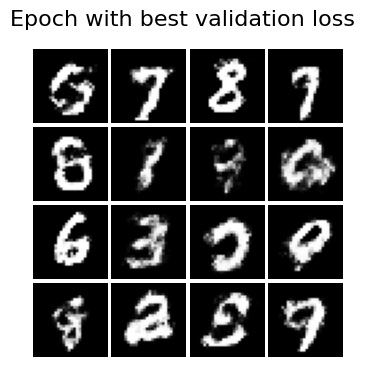

In [271]:
# Inference    
G.load_state_dict(torch.load('checkpoints/G_best.pth'))
G.eval()

save_sample(G, "with best validation loss", mb_size, Z_dim, close = False)

In [272]:
!pip install imageio
import imageio.v2 as imageio
import os

In [280]:
# A piece of code that creates gif from saved samples per epoch to see how the generator evolves.

def create_gif_from_samples(out_dir="out_vanila_GAN", gif_name="training_progress.gif"):
    images = []
    
    # Sort filenames numerically
    filenames = sorted(
        [f for f in os.listdir(out_dir) if f.endswith(".png") and not f.startswith("with")],
        key=lambda x: int(x.split('.')[0])
    )

    for filename in filenames:
        img_path = os.path.join(out_dir, filename)
        images.append(imageio.imread(img_path))

    gif_path = os.path.join(out_dir, gif_name)
    imageio.mimsave(gif_path, images, duration=0.3)  # 0.3s per frame

    print(f"GIF saved to {gif_path}")

In [281]:
create_gif_from_samples()

GIF saved to out_vanila_GAN/training_progress.gif


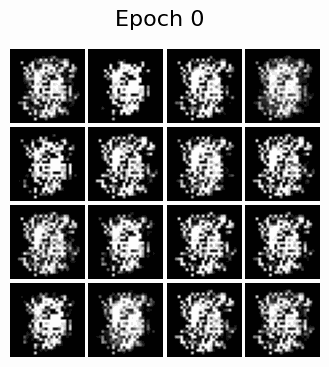

In [282]:

from IPython.display import Image, display

display(Image(filename="out_vanila_GAN/training_progress.gif"))

In [ ]:
#Task 2. Change loss-function

  0%|          | 0/938 [00:00<?, ?it/s]

epoch 0; D_loss: 1.4628; G_loss: 0.6834
Saved Best Models at epoch 0 | G_loss: 0.6834


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 1; D_loss: 1.4632; G_loss: 0.6833
Saved Best Models at epoch 1 | G_loss: 0.6833


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 2; D_loss: 1.4626; G_loss: 0.6832
Saved Best Models at epoch 2 | G_loss: 0.6832


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 3; D_loss: 1.4626; G_loss: 0.6832
Saved Best Models at epoch 3 | G_loss: 0.6832


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 4; D_loss: 1.4626; G_loss: 0.6834


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 5; D_loss: 1.4627; G_loss: 0.6831
Saved Best Models at epoch 5 | G_loss: 0.6831


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 6; D_loss: 1.4629; G_loss: 0.6835


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 7; D_loss: 1.4626; G_loss: 0.6834


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 8; D_loss: 1.4628; G_loss: 0.6831
Saved Best Models at epoch 8 | G_loss: 0.6831


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 9; D_loss: 1.4629; G_loss: 0.6834


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 10; D_loss: 1.4629; G_loss: 0.6833


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 11; D_loss: 1.4627; G_loss: 0.6831


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 12; D_loss: 1.4631; G_loss: 0.6831
Saved Best Models at epoch 12 | G_loss: 0.6831


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 13; D_loss: 1.4627; G_loss: 0.6834


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 14; D_loss: 1.4627; G_loss: 0.6835


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 15; D_loss: 1.4623; G_loss: 0.6831


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 16; D_loss: 1.4626; G_loss: 0.6834


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 17; D_loss: 1.4629; G_loss: 0.6835


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 18; D_loss: 1.4629; G_loss: 0.6834


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 19; D_loss: 1.4629; G_loss: 0.6830
Saved Best Models at epoch 19 | G_loss: 0.6830


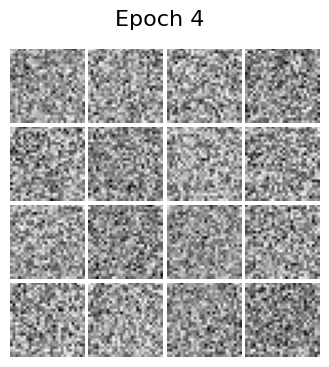

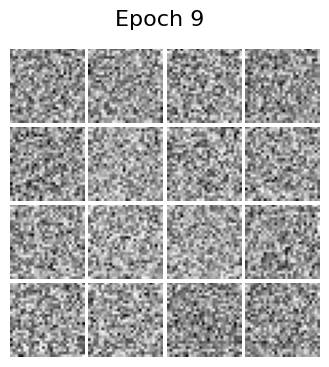

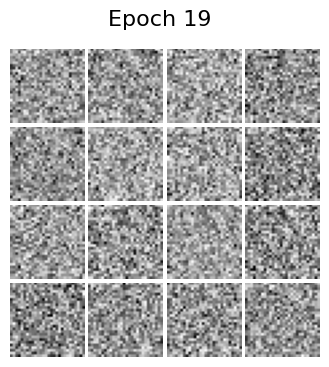

In [299]:
lr = 1e-3
########################### Main #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate models
G2 = Generator(Z_dim, h_dim, X_dim, sigmoid = True).to(device)
D2 = Discriminator(X_dim, h_dim, sigmoid = False).to(device)

# Optimizers
G2_solver = optim.Adam(G2.parameters(), lr=lr)
D2_solver = optim.Adam(D2.parameters(), lr=lr)


#loss_fn = nn.BCEWithLogitsLoss()
loss_fn2 = nn.BCEWithLogitsLoss()

if wandb_log: 
    wandb.init(project="conditional-gan-mnist")

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

#Train epochs
epochs = 20

for epoch in range(epochs):
    G2, D2, G_loss_avg, D_loss_avg= GANTraining(G2, D2, loss_fn2, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G2.state_dict(), os.path.join(save_dir, 'G2_best.pth'))
        torch.save(D2.state_dict(), os.path.join(save_dir, 'D2_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")
    if epoch in [4,9,19]:
        close = False
    else:
        close = True
    save_sample(G2, epoch, mb_size, Z_dim, out_dir = "out_vanila_GAN_loss2", close = close)


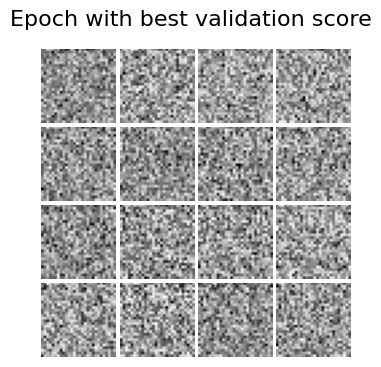

In [298]:
G2.load_state_dict(torch.load('checkpoints/G2_best.pth'))
G2.eval()

save_sample(G2, "with best validation score", mb_size, Z_dim, close = False)

GIF saved to out_vanila_GAN_loss2/training_progress_loss2.gif


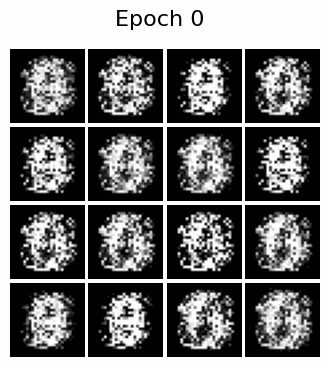

In [291]:
create_gif_from_samples(out_dir = 'out_vanila_GAN_loss2', gif_name = 'training_progress_loss2.gif' )
from IPython.display import Image, display

display(Image(filename="out_vanila_GAN_loss2/training_progress_loss2.gif"))

In [300]:
# The hyperparameters are not tuned for the new loss-function. Here follows
# an attempt to create a model tuned for the new kind of loss. Changes were made to learning rate
# and introduced gradient clipping and learning rate scheduler.

# Hyperparameters
mb_size = 64
Z_dim = 1000
h_dim = 128

# The gradients of the new loss-function seem to be sharper so needed to lower the learning-rate. Also needed different learning
# rate for generator and discriminator as discriminator was overpowering the generator.
lr_g = 4e-4
lr_d = 1e-4

# Load MNIST data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])

train_dataset = datasets.MNIST(root='../MNIST', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=mb_size, shuffle=True)

X_dim = 784  # 28 x 28

# Xavier Initialization
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim, x_dim, sigmoid = True):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)
        self.sigmoid = sigmoid

    def forward(self, z):
        h = F.relu(self.fc1(z))
        if self.sigmoid:
            out = torch.sigmoid(self.fc2(h))
        else:
            out = self.fc2(h)
        return out

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, x_dim, h_dim, sigmoid = True):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)
        self.sigmoid = sigmoid

    def forward(self, x):
        h = F.relu(self.fc1(x))
        if self.sigmoid:
            out = torch.sigmoid(self.fc2(h))
        else:
            out = self.fc2(h)
        return out



# Training
def GANTraining2(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm(train_loader)
    
    for it, (X_real, labels) in enumerate(t):
        # Prepare real data
        X_real = X_real.float().to(device)

        # Sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # ================= Train Discriminator =================
        G_sample = G(z)
        D_real = D(X_real)
        D_fake = D(G_sample.detach())

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        '''
        if it == 20:
            print("\n[ Discriminator Gradients ]")
            for name, param in D.named_parameters():
                if param.grad is not None:
                    print(f"{name}: mean={param.grad.abs().mean().item():.6f}, max={param.grad.abs().max().item():.6f}")
        '''
        torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=5.0)

        D_solver.step()

        # ================= Train Generator ====================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = loss_fn(D_fake, ones_label)
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        '''
        if it == 20:
            print("\n[ Generator Gradients ]")
            for name, param in G.named_parameters():
                if param.grad is not None:
                    print(f"{name}: mean={param.grad.abs().mean().item():.6f}, max={param.grad.abs().max().item():.6f}")
       '''
        # Implemented gradient clipping to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(G.parameters(), max_norm=10.0)
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })

    return G, D, G_loss_avg, D_loss_avg
    


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 0; D_loss: 0.7658; G_loss: 1.5718
Saved Best Models at epoch 0 | G_loss: 1.5718


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 1; D_loss: 0.4790; G_loss: 1.8899


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 2; D_loss: 0.3257; G_loss: 2.2833


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 3; D_loss: 0.4707; G_loss: 1.6348


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 4; D_loss: 0.4948; G_loss: 1.4977
Saved Best Models at epoch 4 | G_loss: 1.4977


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 5; D_loss: 0.4604; G_loss: 1.7269


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 6; D_loss: 0.6557; G_loss: 1.5808


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 7; D_loss: 0.6232; G_loss: 1.6357


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 8; D_loss: 0.6600; G_loss: 1.5862


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 9; D_loss: 0.6071; G_loss: 1.7070


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 10; D_loss: 0.5784; G_loss: 1.6808


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 11; D_loss: 0.6972; G_loss: 1.4578
Saved Best Models at epoch 11 | G_loss: 1.4578


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 12; D_loss: 0.7621; G_loss: 1.4544
Saved Best Models at epoch 12 | G_loss: 1.4544


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 13; D_loss: 0.8562; G_loss: 1.3725
Saved Best Models at epoch 13 | G_loss: 1.3725


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 14; D_loss: 0.7197; G_loss: 1.5140


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 15; D_loss: 0.8520; G_loss: 1.3517
Saved Best Models at epoch 15 | G_loss: 1.3517


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 16; D_loss: 0.7651; G_loss: 1.4002


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 17; D_loss: 0.7630; G_loss: 1.4870


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 18; D_loss: 0.7626; G_loss: 1.5338


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 19; D_loss: 0.7879; G_loss: 1.5005


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 20; D_loss: 0.7209; G_loss: 1.4621


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 21; D_loss: 0.8607; G_loss: 1.3222
Saved Best Models at epoch 21 | G_loss: 1.3222


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 22; D_loss: 0.8574; G_loss: 1.3382


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 23; D_loss: 0.7799; G_loss: 1.4592


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 24; D_loss: 0.8691; G_loss: 1.4171


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 25; D_loss: 0.9988; G_loss: 1.2501
Saved Best Models at epoch 25 | G_loss: 1.2501


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 26; D_loss: 1.0169; G_loss: 1.2200
Saved Best Models at epoch 26 | G_loss: 1.2200


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 27; D_loss: 1.0723; G_loss: 1.1620
Saved Best Models at epoch 27 | G_loss: 1.1620


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 28; D_loss: 1.0266; G_loss: 1.1811


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 29; D_loss: 0.9646; G_loss: 1.2017


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 30; D_loss: 0.8717; G_loss: 1.2980


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 31; D_loss: 0.8514; G_loss: 1.3115


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 32; D_loss: 0.9586; G_loss: 1.2060


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 33; D_loss: 0.8963; G_loss: 1.2535


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 34; D_loss: 0.8099; G_loss: 1.3320


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 35; D_loss: 0.9373; G_loss: 1.2130


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 36; D_loss: 1.0862; G_loss: 1.0928
Saved Best Models at epoch 36 | G_loss: 1.0928


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 37; D_loss: 1.1248; G_loss: 1.0345
Saved Best Models at epoch 37 | G_loss: 1.0345


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 38; D_loss: 1.0144; G_loss: 1.1364


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 39; D_loss: 0.9450; G_loss: 1.2261


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 40; D_loss: 0.9331; G_loss: 1.2424


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 41; D_loss: 1.2753; G_loss: 0.9432
Saved Best Models at epoch 41 | G_loss: 0.9432


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 42; D_loss: 1.3132; G_loss: 0.8900
Saved Best Models at epoch 42 | G_loss: 0.8900


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 43; D_loss: 1.1910; G_loss: 0.9731


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 44; D_loss: 1.1356; G_loss: 1.0127


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 45; D_loss: 1.1305; G_loss: 1.0216


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 46; D_loss: 1.0939; G_loss: 1.0631


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 47; D_loss: 1.0837; G_loss: 1.0830


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 48; D_loss: 1.0630; G_loss: 1.1215


  0%|          | 0/938 [00:00<?, ?it/s]

epoch 49; D_loss: 1.1338; G_loss: 1.0568


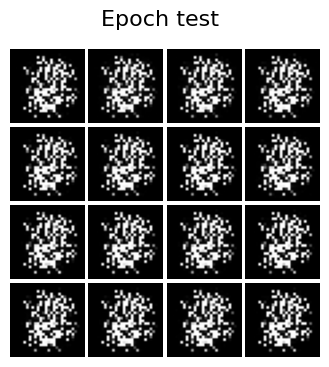

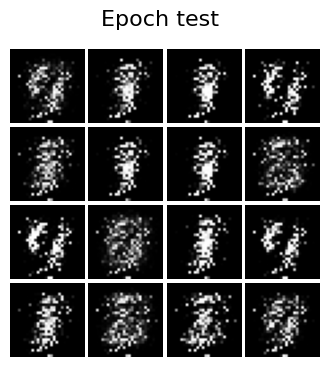

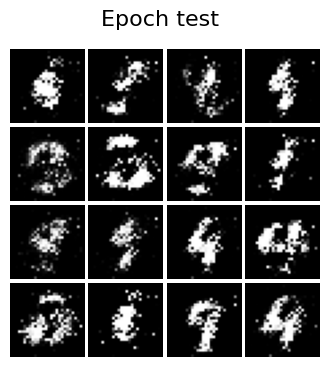

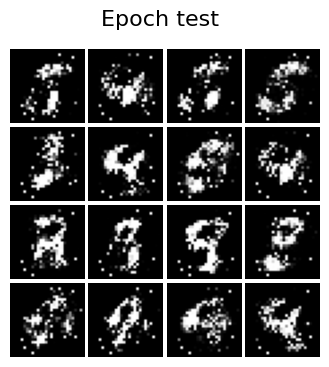

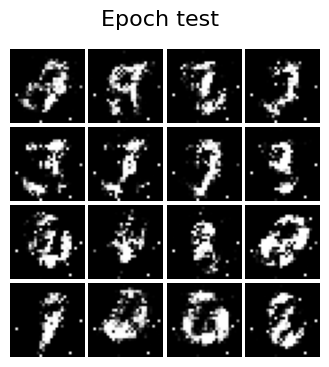

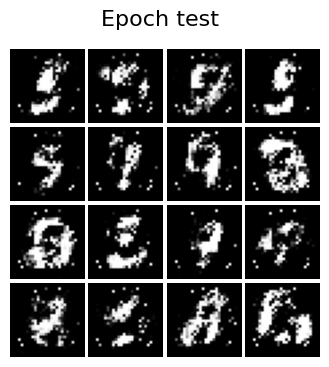

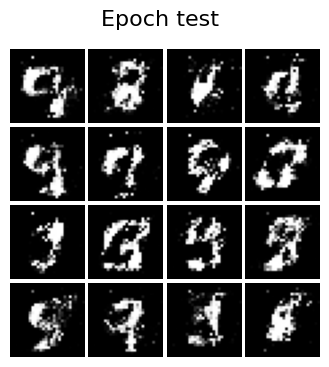

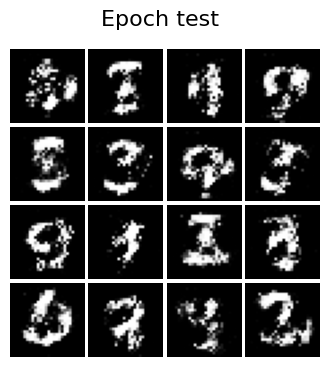

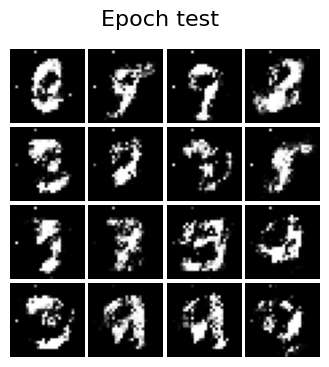

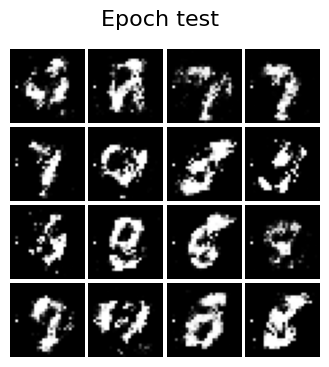

In [295]:


########################### Main #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate models
G3 = Generator(Z_dim, h_dim, X_dim, sigmoid = True).to(device)
D3 = Discriminator(X_dim, h_dim, sigmoid = False).to(device)

# Optimizers
G_solver = optim.Adam(G3.parameters(), lr=lr_g)
D_solver = optim.Adam(D3.parameters(), lr=lr_d)

G_scheduler = torch.optim.lr_scheduler.StepLR(G_solver, step_size=10, gamma=0.5)
D_scheduler = torch.optim.lr_scheduler.StepLR(D_solver, step_size=10, gamma=0.5)


#loss_fn = nn.BCEWithLogitsLoss()
loss_fn2 = nn.BCEWithLogitsLoss()

if wandb_log: 
    wandb.init(project="conditional-gan-mnist")

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

#Train epochs
epochs = 20

for epoch in range(epochs):
    G3, D3, G_loss_avg, D_loss_avg= GANTraining2(G3, D3, loss_fn2, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')
    if epoch % 5 ==0:
        G3.eval()

        save_sample(G3, "test", mb_size, Z_dim, close = False)
        
    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G3.state_dict(), os.path.join(save_dir, 'G3_best.pth'))
        torch.save(D3.state_dict(), os.path.join(save_dir, 'D3_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G3, epoch, mb_size, Z_dim, out_dir = "out_vanila_GAN_loss2_tuned", close = True)
    G_scheduler.step()
    D_scheduler.step()


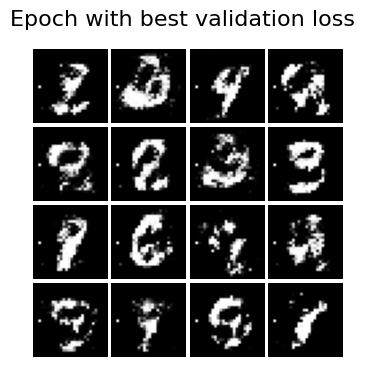

In [296]:
# Inference    
G3.load_state_dict(torch.load('checkpoints/G3_best.pth'))
G3.eval()

save_sample(G3, "with best validation loss", mb_size, Z_dim, close = False)

In [ ]:
# Task 3, create conditional GAN that tries to create a certain digit according to the label

In [128]:

# Training
def cGANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm.tqdm(train_loader)
    nums = list(range(1,10))
    for it, (X_real, labels) in enumerate(t):
        # Real data
        # One hot encode labels
        labels_onehot = F.one_hot(labels, num_classes=10).float().to(device)
        # Prepare real data
        X_real = X_real.float().to(device)
        # Concatenate the label onto the  imagedata
        X_real = torch.cat([X_real, labels_onehot], dim = 1).to(device)

        # Create base for fake images
        # Sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        
        # Add one-hot labels, re-use the labels from the real data as the batch_size is the same.
        z = torch.cat([z, labels_onehot.to(device)], dim=1).to(device)
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # ================= Train Discriminator =================
        G_sample = G(z)
        D_real = D(X_real)
        D_fake_input = torch.cat([G_sample.detach(), labels_onehot], dim = 1).to(device)
        D_fake = D(D_fake_input)

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # ================= Train Generator ====================
        '''
        Try to reuse z
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        # Add one-hot labels, same as for real data
        z = torch.cat([z, labels_onehot.to(device)], dim=1) 
        '''
        G_sample = G(z)
        D_fake_input = torch.cat([G_sample, labels_onehot], dim=1) 
        D_fake = D(D_fake_input)

        G_loss = loss_fn(D_fake, ones_label)
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })

    return G, D, G_loss_avg, D_loss_avg
    


def save_sample_c(G, epoch, mb_size, Z_dim, out_dir = "out_cGAN", close = True):
    out_dir = "out_cGAN"
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        
        # Generate labels: 0–9 repeated or sampled
        sample_labels = torch.tensor([i % 10 for i in range(mb_size)], device=device)
        sample_labels_onehot = F.one_hot(sample_labels, num_classes=10).float()
        
        z_cond = torch.cat([z, sample_labels_onehot], dim=1)
        samples = G(z_cond).detach().cpu().numpy()[:16]
        sample_labels = sample_labels.cpu().numpy()[:16]  # For plotting

    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.2, hspace=0.5)  # Leave space for labels

    for i, (sample, label) in enumerate(zip(samples, sample_labels)):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
        ax.set_title(str(label), fontsize=8, pad=2)

    fig.suptitle(f"Epoch {epoch}", fontsize=16)

    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    if close:
        plt.close(fig)


In [ ]:
# Instantiate models
G4 = Generator(Z_dim + 10 , h_dim, X_dim, sigmoid = True).to(device)
D4 = Discriminator(X_dim + 10, h_dim, sigmoid = False).to(device)

100%|██████████| 938/938 [00:10<00:00, 91.36it/s]


epoch 0; D_loss: 1.2028; G_loss: 1.0142
Saved Best Models at epoch 0 | G_loss: 1.0142


100%|██████████| 938/938 [00:10<00:00, 92.52it/s]


epoch 1; D_loss: 1.1824; G_loss: 1.0344


100%|██████████| 938/938 [00:10<00:00, 92.09it/s]


epoch 2; D_loss: 1.1762; G_loss: 1.0219


100%|██████████| 938/938 [00:10<00:00, 91.82it/s]


epoch 3; D_loss: 1.1832; G_loss: 1.0092
Saved Best Models at epoch 3 | G_loss: 1.0092


100%|██████████| 938/938 [00:10<00:00, 92.87it/s]


epoch 4; D_loss: 1.1800; G_loss: 1.0152


100%|██████████| 938/938 [00:10<00:00, 92.38it/s]


epoch 5; D_loss: 1.1959; G_loss: 1.0147


100%|██████████| 938/938 [00:10<00:00, 91.70it/s]


epoch 6; D_loss: 1.2063; G_loss: 0.9902
Saved Best Models at epoch 6 | G_loss: 0.9902


100%|██████████| 938/938 [00:10<00:00, 93.29it/s]


epoch 7; D_loss: 1.2054; G_loss: 0.9850
Saved Best Models at epoch 7 | G_loss: 0.9850


100%|██████████| 938/938 [00:10<00:00, 90.45it/s]


epoch 8; D_loss: 1.2102; G_loss: 0.9795
Saved Best Models at epoch 8 | G_loss: 0.9795


100%|██████████| 938/938 [00:09<00:00, 94.53it/s]


epoch 9; D_loss: 1.2100; G_loss: 0.9768
Saved Best Models at epoch 9 | G_loss: 0.9768


100%|██████████| 938/938 [00:10<00:00, 93.45it/s]


epoch 10; D_loss: 1.1977; G_loss: 0.9588
Saved Best Models at epoch 10 | G_loss: 0.9588


100%|██████████| 938/938 [00:10<00:00, 93.41it/s]


epoch 11; D_loss: 1.2092; G_loss: 0.9398
Saved Best Models at epoch 11 | G_loss: 0.9398


100%|██████████| 938/938 [00:10<00:00, 88.36it/s]


epoch 12; D_loss: 1.2152; G_loss: 0.9302
Saved Best Models at epoch 12 | G_loss: 0.9302


100%|██████████| 938/938 [00:10<00:00, 93.05it/s]


epoch 13; D_loss: 1.2150; G_loss: 0.9274
Saved Best Models at epoch 13 | G_loss: 0.9274


100%|██████████| 938/938 [00:10<00:00, 93.17it/s]


epoch 14; D_loss: 1.2247; G_loss: 0.9212
Saved Best Models at epoch 14 | G_loss: 0.9212


100%|██████████| 938/938 [00:10<00:00, 93.29it/s]


epoch 15; D_loss: 1.2176; G_loss: 0.9247


100%|██████████| 938/938 [00:10<00:00, 91.86it/s]


epoch 16; D_loss: 1.2245; G_loss: 0.9176
Saved Best Models at epoch 16 | G_loss: 0.9176


100%|██████████| 938/938 [00:10<00:00, 93.28it/s]


epoch 17; D_loss: 1.2200; G_loss: 0.9194


100%|██████████| 938/938 [00:10<00:00, 92.01it/s]


epoch 18; D_loss: 1.2322; G_loss: 0.9127
Saved Best Models at epoch 18 | G_loss: 0.9127


100%|██████████| 938/938 [00:10<00:00, 92.17it/s]


epoch 19; D_loss: 1.2301; G_loss: 0.9113
Saved Best Models at epoch 19 | G_loss: 0.9113


100%|██████████| 938/938 [00:10<00:00, 91.34it/s]


epoch 20; D_loss: 1.2305; G_loss: 0.9064
Saved Best Models at epoch 20 | G_loss: 0.9064


100%|██████████| 938/938 [00:10<00:00, 90.63it/s]


epoch 21; D_loss: 1.2317; G_loss: 0.9021
Saved Best Models at epoch 21 | G_loss: 0.9021


100%|██████████| 938/938 [00:10<00:00, 92.76it/s]


epoch 22; D_loss: 1.2311; G_loss: 0.9032


100%|██████████| 938/938 [00:10<00:00, 91.04it/s]


epoch 23; D_loss: 1.2263; G_loss: 0.9071


100%|██████████| 938/938 [00:10<00:00, 92.13it/s]


epoch 24; D_loss: 1.2218; G_loss: 0.9053


100%|██████████| 938/938 [00:10<00:00, 93.00it/s]


epoch 25; D_loss: 1.2401; G_loss: 0.8913
Saved Best Models at epoch 25 | G_loss: 0.8913


100%|██████████| 938/938 [00:10<00:00, 91.77it/s]


epoch 26; D_loss: 1.2427; G_loss: 0.8890
Saved Best Models at epoch 26 | G_loss: 0.8890


100%|██████████| 938/938 [00:10<00:00, 92.32it/s]


epoch 27; D_loss: 1.2256; G_loss: 0.8984


100%|██████████| 938/938 [00:10<00:00, 92.89it/s]


epoch 28; D_loss: 1.2335; G_loss: 0.8981


100%|██████████| 938/938 [00:08<00:00, 115.99it/s]


epoch 29; D_loss: 1.2571; G_loss: 0.8822
Saved Best Models at epoch 29 | G_loss: 0.8822


100%|██████████| 938/938 [00:09<00:00, 95.31it/s] 


epoch 30; D_loss: 1.2487; G_loss: 0.8852


100%|██████████| 938/938 [00:10<00:00, 87.79it/s]


epoch 31; D_loss: 1.2364; G_loss: 0.8929


100%|██████████| 938/938 [00:10<00:00, 93.21it/s]


epoch 32; D_loss: 1.2283; G_loss: 0.8963


100%|██████████| 938/938 [00:10<00:00, 92.81it/s]


epoch 33; D_loss: 1.2304; G_loss: 0.8938


100%|██████████| 938/938 [00:10<00:00, 86.99it/s]


epoch 34; D_loss: 1.2376; G_loss: 0.8869


100%|██████████| 938/938 [00:09<00:00, 94.56it/s] 


epoch 35; D_loss: 1.2501; G_loss: 0.8800
Saved Best Models at epoch 35 | G_loss: 0.8800


100%|██████████| 938/938 [00:07<00:00, 119.28it/s]


epoch 36; D_loss: 1.2588; G_loss: 0.8739
Saved Best Models at epoch 36 | G_loss: 0.8739


100%|██████████| 938/938 [00:09<00:00, 103.70it/s]


epoch 37; D_loss: 1.2582; G_loss: 0.8739
Saved Best Models at epoch 37 | G_loss: 0.8739


100%|██████████| 938/938 [00:10<00:00, 93.29it/s]


epoch 38; D_loss: 1.2485; G_loss: 0.8800


100%|██████████| 938/938 [00:10<00:00, 91.85it/s]


epoch 39; D_loss: 1.2407; G_loss: 0.8849


100%|██████████| 938/938 [00:10<00:00, 89.03it/s]


epoch 40; D_loss: 1.2380; G_loss: 0.8869


100%|██████████| 938/938 [00:10<00:00, 93.76it/s]


epoch 41; D_loss: 1.2352; G_loss: 0.8891


100%|██████████| 938/938 [00:10<00:00, 91.53it/s]


epoch 42; D_loss: 1.2382; G_loss: 0.8869


100%|██████████| 938/938 [00:10<00:00, 93.26it/s]


epoch 43; D_loss: 1.2431; G_loss: 0.8837


100%|██████████| 938/938 [00:10<00:00, 93.46it/s]


epoch 44; D_loss: 1.2459; G_loss: 0.8830


100%|██████████| 938/938 [00:09<00:00, 94.22it/s]


epoch 45; D_loss: 1.2525; G_loss: 0.8778


100%|██████████| 938/938 [00:10<00:00, 92.43it/s]


epoch 46; D_loss: 1.2580; G_loss: 0.8748


100%|██████████| 938/938 [00:10<00:00, 89.57it/s]


epoch 47; D_loss: 1.2618; G_loss: 0.8740


100%|██████████| 938/938 [00:10<00:00, 93.52it/s]


epoch 48; D_loss: 1.2631; G_loss: 0.8725
Saved Best Models at epoch 48 | G_loss: 0.8725


100%|██████████| 938/938 [00:10<00:00, 93.65it/s]


epoch 49; D_loss: 1.2617; G_loss: 0.8706
Saved Best Models at epoch 49 | G_loss: 0.8706


100%|██████████| 938/938 [00:10<00:00, 91.45it/s]


epoch 50; D_loss: 1.2613; G_loss: 0.8707


100%|██████████| 938/938 [00:10<00:00, 92.80it/s]


epoch 51; D_loss: 1.2603; G_loss: 0.8695
Saved Best Models at epoch 51 | G_loss: 0.8695


100%|██████████| 938/938 [00:10<00:00, 92.33it/s]


epoch 52; D_loss: 1.2579; G_loss: 0.8715


100%|██████████| 938/938 [00:10<00:00, 92.87it/s]


epoch 53; D_loss: 1.2560; G_loss: 0.8726


100%|██████████| 938/938 [00:10<00:00, 91.35it/s]


epoch 54; D_loss: 1.2527; G_loss: 0.8750


100%|██████████| 938/938 [00:10<00:00, 92.67it/s]


epoch 55; D_loss: 1.2516; G_loss: 0.8747


100%|██████████| 938/938 [00:10<00:00, 88.90it/s]


epoch 56; D_loss: 1.2512; G_loss: 0.8752


100%|██████████| 938/938 [00:10<00:00, 91.93it/s]


epoch 57; D_loss: 1.2483; G_loss: 0.8759


100%|██████████| 938/938 [00:10<00:00, 91.65it/s]


epoch 58; D_loss: 1.2475; G_loss: 0.8762


100%|██████████| 938/938 [00:10<00:00, 92.37it/s]


epoch 59; D_loss: 1.2472; G_loss: 0.8775


100%|██████████| 938/938 [00:10<00:00, 92.97it/s]


epoch 60; D_loss: 1.2452; G_loss: 0.8771


100%|██████████| 938/938 [00:10<00:00, 93.76it/s]


epoch 61; D_loss: 1.2451; G_loss: 0.8776


100%|██████████| 938/938 [00:10<00:00, 93.70it/s]


epoch 62; D_loss: 1.2457; G_loss: 0.8766


100%|██████████| 938/938 [00:10<00:00, 92.19it/s]


epoch 63; D_loss: 1.2479; G_loss: 0.8761


100%|██████████| 938/938 [00:10<00:00, 92.42it/s]


epoch 64; D_loss: 1.2481; G_loss: 0.8765


100%|██████████| 938/938 [00:10<00:00, 93.12it/s]


epoch 65; D_loss: 1.2453; G_loss: 0.8757


100%|██████████| 938/938 [00:10<00:00, 92.19it/s]


epoch 66; D_loss: 1.2483; G_loss: 0.8763


100%|██████████| 938/938 [00:10<00:00, 92.11it/s]


epoch 67; D_loss: 1.2483; G_loss: 0.8741


100%|██████████| 938/938 [00:10<00:00, 92.00it/s]


epoch 68; D_loss: 1.2472; G_loss: 0.8746


100%|██████████| 938/938 [00:10<00:00, 92.14it/s]


epoch 69; D_loss: 1.2506; G_loss: 0.8730


100%|██████████| 938/938 [00:10<00:00, 91.89it/s]


epoch 70; D_loss: 1.2480; G_loss: 0.8761


100%|██████████| 938/938 [00:10<00:00, 90.66it/s]


epoch 71; D_loss: 1.2505; G_loss: 0.8740


100%|██████████| 938/938 [00:10<00:00, 92.82it/s]


epoch 72; D_loss: 1.2508; G_loss: 0.8740


100%|██████████| 938/938 [00:10<00:00, 90.70it/s] 


epoch 73; D_loss: 1.2514; G_loss: 0.8736


100%|██████████| 938/938 [00:10<00:00, 92.81it/s]


epoch 74; D_loss: 1.2507; G_loss: 0.8742


100%|██████████| 938/938 [00:10<00:00, 91.77it/s] 


epoch 75; D_loss: 1.2507; G_loss: 0.8726


100%|██████████| 938/938 [00:10<00:00, 91.50it/s] 


epoch 76; D_loss: 1.2493; G_loss: 0.8757


100%|██████████| 938/938 [00:10<00:00, 93.01it/s]


epoch 77; D_loss: 1.2510; G_loss: 0.8724


100%|██████████| 938/938 [00:10<00:00, 86.90it/s]


epoch 78; D_loss: 1.2509; G_loss: 0.8742


100%|██████████| 938/938 [00:10<00:00, 91.89it/s]


epoch 79; D_loss: 1.2532; G_loss: 0.8725


100%|██████████| 938/938 [00:09<00:00, 94.02it/s] 


epoch 80; D_loss: 1.2536; G_loss: 0.8710


100%|██████████| 938/938 [00:10<00:00, 92.84it/s]


epoch 81; D_loss: 1.2520; G_loss: 0.8721


100%|██████████| 938/938 [00:10<00:00, 91.30it/s]


epoch 82; D_loss: 1.2521; G_loss: 0.8727


100%|██████████| 938/938 [00:10<00:00, 93.69it/s]


epoch 83; D_loss: 1.2545; G_loss: 0.8713


100%|██████████| 938/938 [00:10<00:00, 93.65it/s]


epoch 84; D_loss: 1.2528; G_loss: 0.8718


100%|██████████| 938/938 [00:10<00:00, 91.50it/s]


epoch 85; D_loss: 1.2519; G_loss: 0.8741


100%|██████████| 938/938 [00:10<00:00, 92.66it/s]


epoch 86; D_loss: 1.2529; G_loss: 0.8727


100%|██████████| 938/938 [00:10<00:00, 90.73it/s]


epoch 87; D_loss: 1.2526; G_loss: 0.8725


100%|██████████| 938/938 [00:10<00:00, 93.20it/s]


epoch 88; D_loss: 1.2534; G_loss: 0.8714


100%|██████████| 938/938 [00:10<00:00, 92.40it/s]


epoch 89; D_loss: 1.2533; G_loss: 0.8743


100%|██████████| 938/938 [00:10<00:00, 92.58it/s]


epoch 90; D_loss: 1.2542; G_loss: 0.8703


100%|██████████| 938/938 [00:10<00:00, 92.83it/s]


epoch 91; D_loss: 1.2559; G_loss: 0.8687
Saved Best Models at epoch 91 | G_loss: 0.8687


100%|██████████| 938/938 [00:10<00:00, 93.13it/s]


epoch 92; D_loss: 1.2534; G_loss: 0.8727


100%|██████████| 938/938 [00:10<00:00, 92.03it/s]


epoch 93; D_loss: 1.2528; G_loss: 0.8730


100%|██████████| 938/938 [00:10<00:00, 93.00it/s]


epoch 94; D_loss: 1.2534; G_loss: 0.8726


100%|██████████| 938/938 [00:10<00:00, 93.05it/s]


epoch 95; D_loss: 1.2572; G_loss: 0.8685
Saved Best Models at epoch 95 | G_loss: 0.8685


/tmp/ipykernel_1030908/2291703476.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(4, 4))
100%|██████████| 938/938 [00:09<00:00, 94.05it/s]


epoch 96; D_loss: 1.2526; G_loss: 0.8750


100%|██████████| 938/938 [00:10<00:00, 91.06it/s]


epoch 97; D_loss: 1.2540; G_loss: 0.8709


100%|██████████| 938/938 [00:10<00:00, 91.25it/s]


epoch 98; D_loss: 1.2527; G_loss: 0.8727


100%|██████████| 938/938 [00:10<00:00, 92.05it/s]


epoch 99; D_loss: 1.2534; G_loss: 0.8719


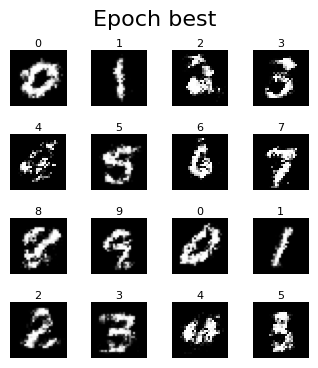

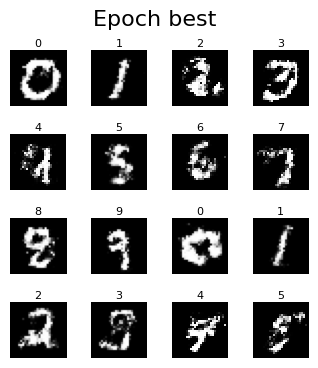

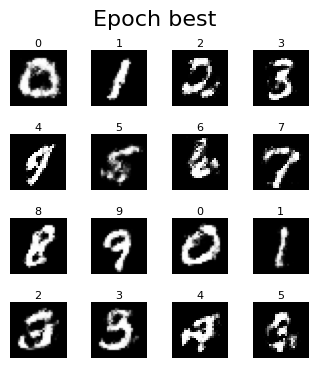

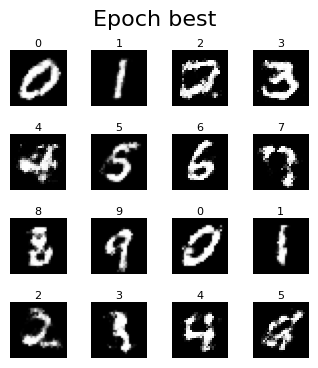

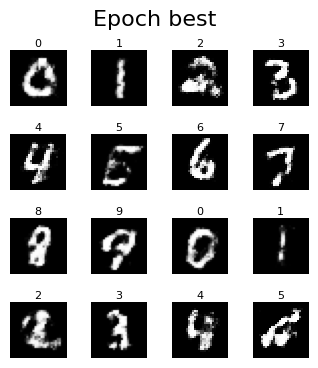

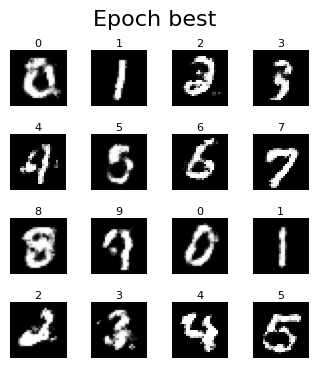

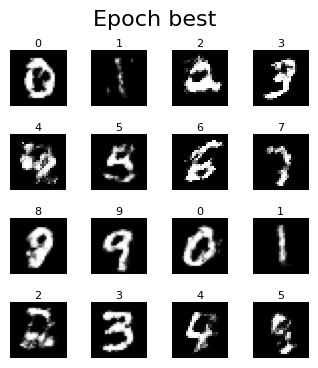

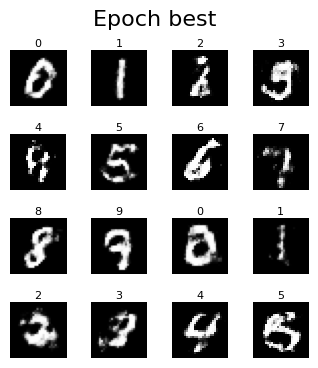

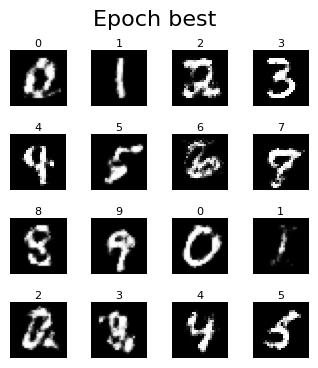

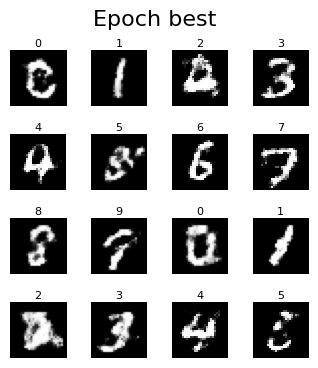

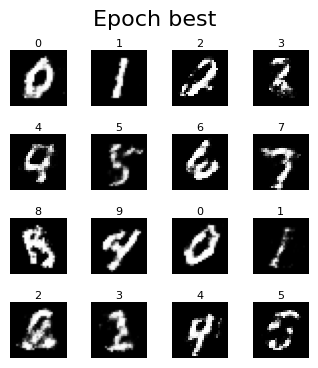

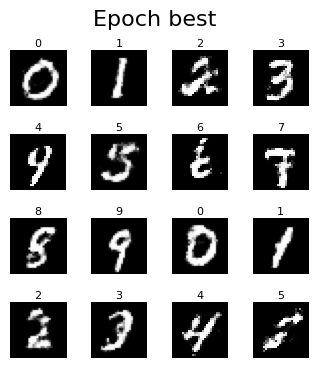

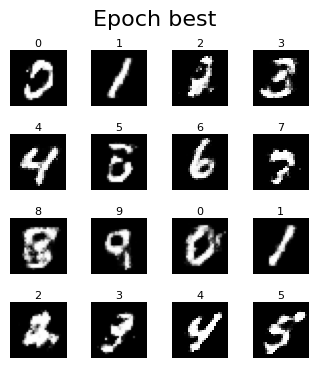

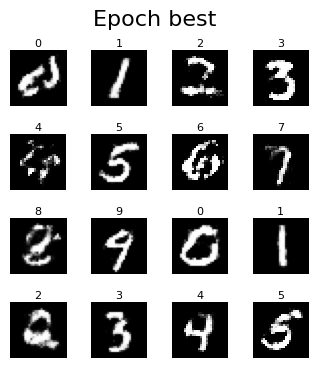

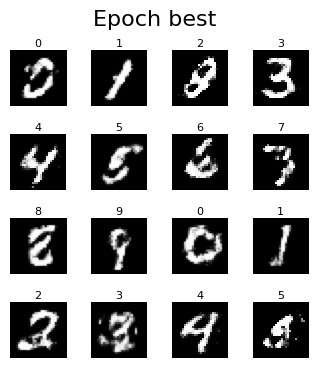

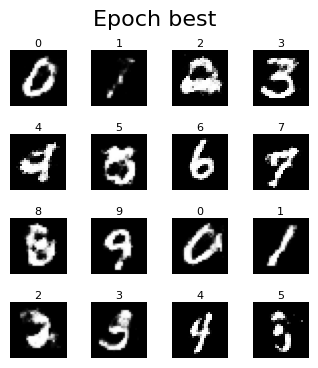

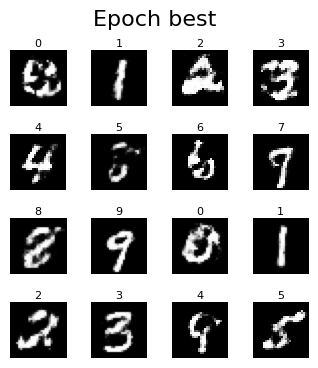

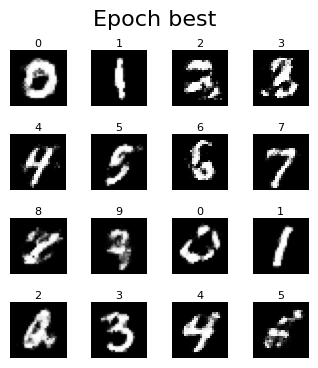

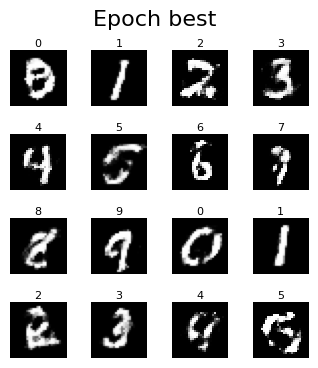

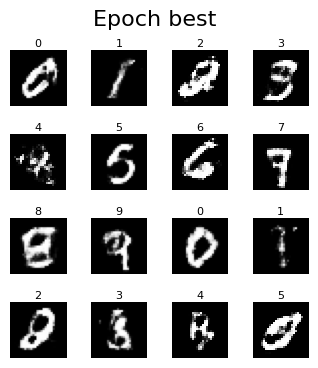

In [135]:
lr_g = 5e-4
lr_d = 1e-4

########################### Main #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



# Optimizers
G_solver = optim.Adam(G4.parameters(), lr=lr_g)
D_solver = optim.Adam(D4.parameters(), lr=lr_d)

G_scheduler = torch.optim.lr_scheduler.StepLR(G_solver, step_size=10, gamma=0.5)
D_scheduler = torch.optim.lr_scheduler.StepLR(D_solver, step_size=10, gamma=0.5)


#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = nn.BCEWithLogitsLoss()

if wandb_log: 
    wandb.init(project="conditional-gan-mnist")

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })

best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

#Train epochs
epochs = 100

for epoch in range(epochs):
    G4, D4, G_loss_avg, D_loss_avg= cGANTraining(G4, D4, loss_fn, train_loader)

    print(f'epoch {epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')
    if epoch % 5 ==0:
        G4.eval()

        save_sample_c(G4, "best", mb_size, Z_dim, close = False)
        
    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G4.state_dict(), os.path.join(save_dir, 'G4_best.pth'))
        torch.save(D4.state_dict(), os.path.join(save_dir, 'D4_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample_c(G4, epoch, mb_size, Z_dim, out_dir = "out_cGAN", close = True)
    G_scheduler.step()
    D_scheduler.step()

GIF saved to out_cGAN/training_progress_cGAN.gif


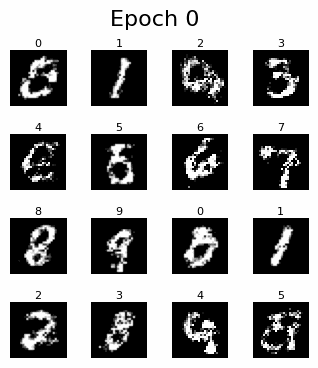

In [290]:
create_gif_from_samples(out_dir = "out_cGAN", gif_name = "training_progress_cGAN.gif")
display(Image(filename="out_cGAN/training_progress_cGAN.gif"))


In [ ]:
# The architecture is not enough to create discernible digits

In [ ]:
# Task 4
# First create CNN MNIst classifier model

In [139]:
# Import and split data into train, validation and test loaders
from sklearn.model_selection import train_test_split

batch_size = 64

# Load MNIST data
transform2 = transforms.Compose([
    transforms.ToTensor(),
    ])


val_test = datasets.MNIST(root='../MNIST', train=False, transform=transform2, download=True)
tr_dataset = datasets.MNIST(root='../MNIST', train=True, transform=transform2, download=True)

# Split the test-data to test and validation sets, 50/50.
val_dataset, test_dataset = train_test_split(val_test, test_size = 0.5, random_state = 42)

tr_loader = DataLoader(tr_dataset, batch_size = batch_size, shuffle = True)
v_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
te_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)



In [147]:
for data, labels in tr_loader:
    print("Batch shape:", data.shape)
    print("Label shape:", labels.shape)
    break  # just check one batch

Batch shape: torch.Size([64, 1, 28, 28])
Label shape: torch.Size([64])


In [153]:
class CNN_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,24,kernel_size = 3, stride = 1, padding = 1, padding_mode = 'reflect')
        self.conv2 = nn.Conv2d(24,24,kernel_size = 3, stride = 1, padding = 1, padding_mode = 'reflect')
        self.maxpool = nn.MaxPool2d(2,stride = 2)
        self.fc = nn.Linear(24*14*14,10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.bn1 = nn.BatchNorm2d(24)
        self.bn2 = nn.BatchNorm2d(24)
        
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.flatten(x)
        x = self.fc(x)

        return x
        

In [154]:
lr = 1e-4

cnn_model = CNN_MNIST().to(device)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [150]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report

Epoch 0: Training loss: 0.085, Validation loss: 0.062
Epoch 1: Training loss: 0.059, Validation loss: 0.047
Epoch 2: Training loss: 0.047, Validation loss: 0.039
Epoch 3: Training loss: 0.039, Validation loss: 0.038
Epoch 4: Training loss: 0.033, Validation loss: 0.034
Epoch 5: Training loss: 0.029, Validation loss: 0.034
Epoch 6: Training loss: 0.025, Validation loss: 0.032
Epoch 7: Training loss: 0.021, Validation loss: 0.032
Epoch 8: Training loss: 0.019, Validation loss: 0.032
Epoch 9: Training loss: 0.016, Validation loss: 0.031
Epoch 10: Training loss: 0.014, Validation loss: 0.034
Epoch 11: Training loss: 0.012, Validation loss: 0.031
Epoch 12: Training loss: 0.010, Validation loss: 0.033
Epoch 13: Training loss: 0.009, Validation loss: 0.031
Epoch 14: Training loss: 0.008, Validation loss: 0.037
Epoch 15: Training loss: 0.007, Validation loss: 0.029
Epoch 16: Training loss: 0.006, Validation loss: 0.031
Epoch 17: Training loss: 0.005, Validation loss: 0.032
Epoch 18: Training l

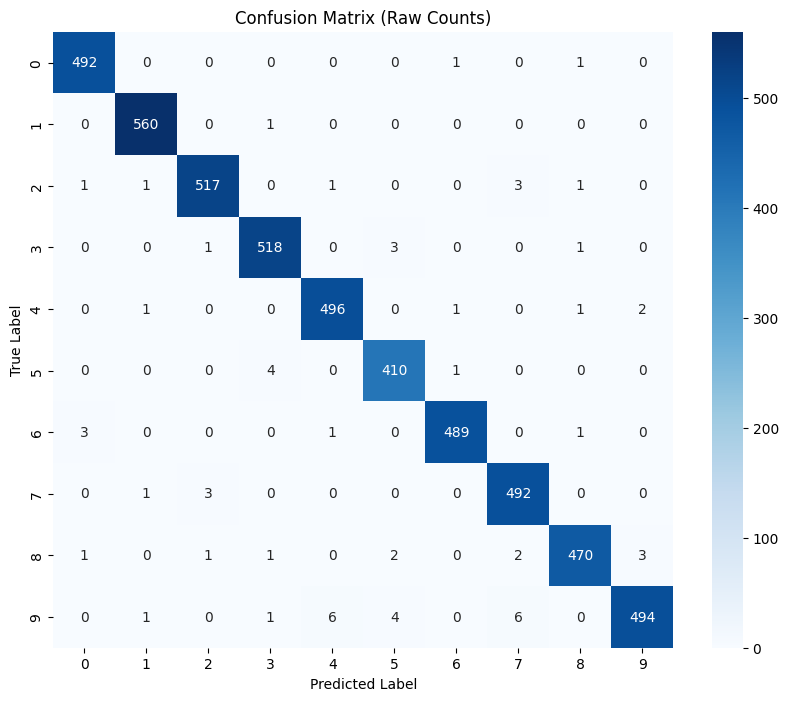

              precision    recall  f1-score   support

           0      0.990     0.996     0.993       494
           1      0.993     0.998     0.996       561
           2      0.990     0.987     0.989       524
           3      0.987     0.990     0.989       523
           4      0.984     0.990     0.987       501
           5      0.979     0.988     0.983       415
           6      0.994     0.990     0.992       494
           7      0.978     0.992     0.985       496
           8      0.989     0.979     0.984       480
           9      0.990     0.965     0.977       512

    accuracy                          0.988      5000
   macro avg      0.987     0.988     0.987      5000
weighted avg      0.988     0.988     0.988      5000



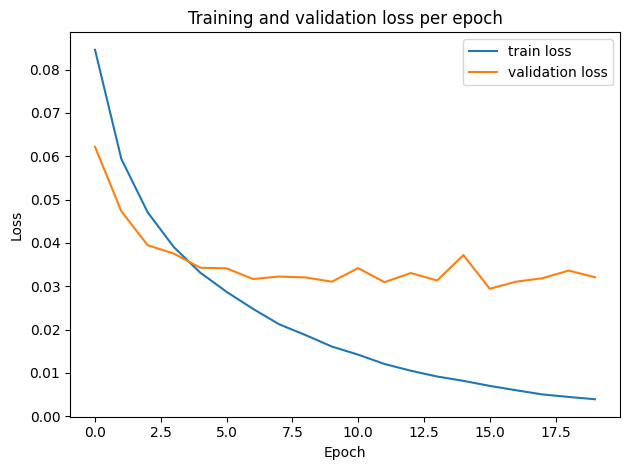

In [157]:
epochs = 20
train_loss_lst = []
val_loss_lst = []
for epoch in range(epochs):
    cnn_model.train()
    batch_loss = 0
    
    for data, labels in tr_loader:
        data = data.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        output = cnn_model(data)
        loss = criterion(output,labels)
        
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
    train_mean_loss = batch_loss / len(tr_loader)
    train_loss_lst.append(train_mean_loss)

    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, labels in v_loader:
            data = data.to(device)
            labels = labels.to(device)
            
            output = cnn_model(data)
            loss = criterion(output,labels)
            val_loss += loss.item()
        val_mean_loss = val_loss/ len(v_loader)
        val_loss_lst.append(val_mean_loss)

    print(f'Epoch {epoch}: Training loss: {train_mean_loss:.3f}, Validation loss: {val_mean_loss:.3f}')

cnn_model.eval()
test_loss = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for data, labels in te_loader:
        data = data.to(device)
        labels = labels.to(device)
            
        output = cnn_model(data)
        loss = criterion(output,labels)
        test_loss += loss.item()
        preds = torch.argmax(output, dim =1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    test_mean_loss = test_loss/ len(te_loader)

print(f'Final test loss: {test_mean_loss:.3f}')

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Raw Counts)')
plt.show()

print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)], digits=3))

plt.plot(list(range(epochs)),train_loss_lst, label = 'train loss')
plt.plot(list(range(epochs)),val_loss_lst, label = 'validation loss')
plt.title('Training and validation loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [255]:
# Extract 10 images of the digit 4

four_images = []
four_labels = []

for data, labels in te_loader:
    for i in range(len(labels)):
        if labels[i].item() == 4:
            four_images.append(data[i])
            four_labels.append(labels[i])
        if len(four_images) == 10:
            break
    if len(four_images) == 10:
        break

# Convert to batch
x_batch = torch.stack(four_images).to(device)
y_true = torch.tensor(four_labels).to(device)

In [256]:
# Generate adversarial steps by feeding the four's to the model but with the 9 label and then changing the image to better align
# with that label

def generate_adversarial_steps(model, images, target_labels, steps=3, epsilon=0.1):
    model.eval()
    x = images.clone().detach().to(device)
    x.requires_grad = True
    print(target_labels)
    adv_steps = [x.detach().clone()]  # Step 0 = original image

    for step in range(steps):
        output = model(x)
        loss = F.cross_entropy(output, target_labels)
        model.zero_grad()
        loss.backward()

        # FGSM step, Fast Gradient Sign Method
        # the gradient of the loss with respect to the image data
        grad = x.grad.data
        x = x - (epsilon / steps) * grad.sign()
        x = torch.clamp(x, 0, 1).detach()
        x.requires_grad = True

        adv_steps.append(x.clone().detach())
        print(f"Step {step}: grad mean = {grad.abs().mean().item():.6f}")

    return adv_steps

In [257]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Funtion to plot the original and adversarial images with probabilities for each class as titles.
def plot_adversarial_matrix(model, adv_steps_list, labels_true, labels_target, step_count=3):
    model.eval()
    class_names = [str(i) for i in range(10)]

    
    fig, axes = plt.subplots(10, step_count + 1, figsize=(step_count * 3, 30))

    for step in range(step_count + 1):
        step_images = adv_steps_list[step]
        with torch.no_grad():
            probs = F.softmax(model(step_images), dim=1).cpu().numpy()
            
            for i in range(10):
                img = step_images[i].cpu().squeeze()
                if i == 0:
                    print(f'{step}, {i} {probs[i]}')
                prob_4 = probs[i][4]
                prob_9 = probs[i][9]
        
                ax = axes[i, step]
                ax.imshow(img, cmap='gray')
                ax.axis('off')
                if step == 0:
                    ax.set_title(f"Original\nP(4): {prob_4:.2f}, P(9): {prob_9:.2f}", fontsize=8)
                else:
                    ax.set_title(f"Step {step}\nP(4): {prob_4:.2f}, P(9): {prob_9:.2f}", fontsize=8)
    plt.tight_layout()
    plt.show()

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')
Step 0: grad mean = 0.065910
Step 1: grad mean = 0.069507
Step 2: grad mean = 0.069418
0, 0 [2.13623661e-13 1.38309059e-10 8.96133667e-10 4.14248844e-12
 1.00000000e+00 1.23411255e-11 1.94338835e-14 3.95101535e-10
 2.58910237e-11 2.88128632e-08]
1, 0 [2.8797990e-12 1.9690276e-09 2.8733856e-08 2.2463841e-10 9.9999118e-01
 5.4045129e-10 5.7393874e-13 4.5668842e-09 1.2828112e-09 8.7707349e-06]
2, 0 [4.9173630e-11 9.1518274e-08 1.9829381e-06 1.8170811e-08 9.8950106e-01
 1.7075889e-08 1.1498157e-11 1.4916436e-07 1.4697983e-07 1.0496592e-02]
3, 0 [6.0931163e-11 3.4138296e-08 4.0696686e-06 2.6525805e-07 2.9806511e-02
 2.3551840e-08 1.9867325e-11 9.6374585e-08 3.0901351e-06 9.7018594e-01]


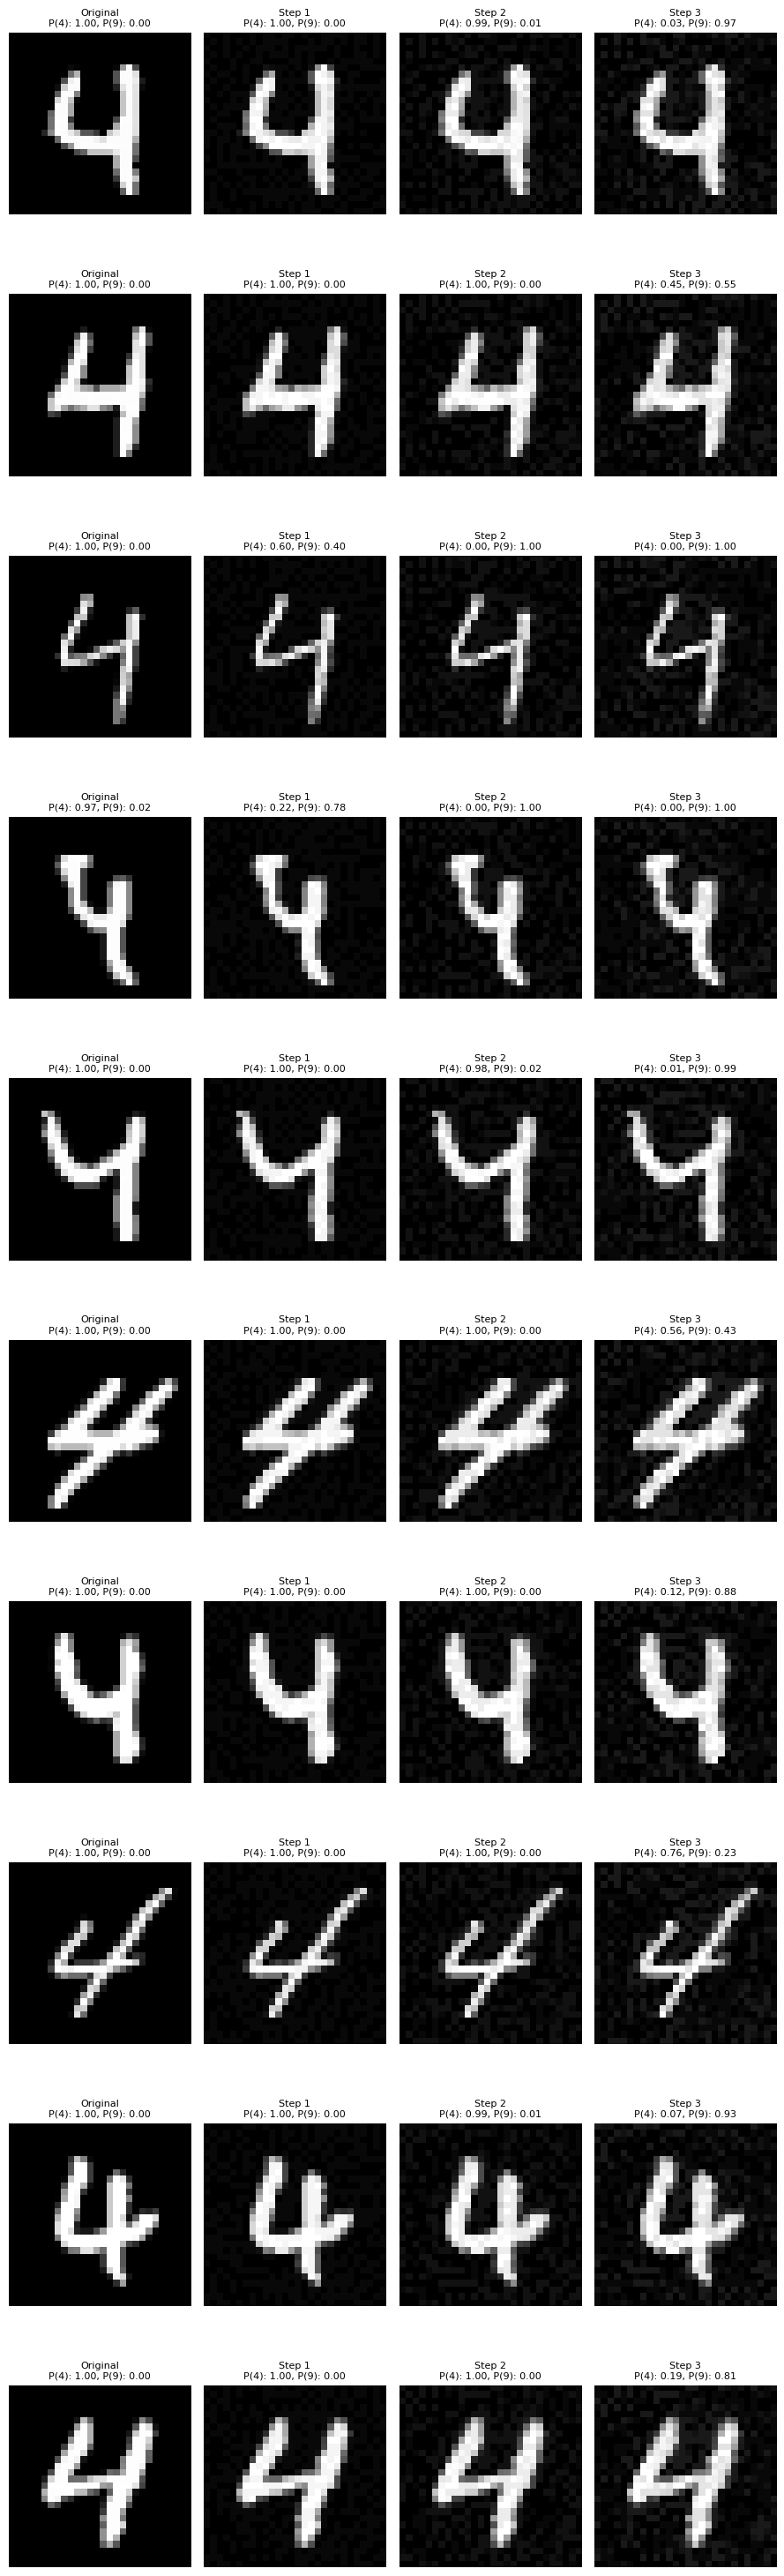

In [258]:
# Create fake target labels (e.g., push them toward class 9)
target_labels = torch.tensor([9] * 10).to(device)

# Generate adversarial images
x_adv_batch = generate_adversarial_images(cnn_model, x_batch, target_labels)


# Generate all adversarial steps
adv_steps = generate_adversarial_steps(cnn_model, x_batch, target_labels, steps=3)

# Plot the matrix of original and adversarial images
plot_adversarial_matrix(cnn_model, adv_steps, y_true, target_labels, step_count=3)

In [ ]:
''' Task 5. Stable diffusion

In [208]:
# Downloads and installations for diffusion model
!pip install einops
!pip install lpips

import torchvision
# Import the 'functools' module for higher-order functions.
import functools

# Import the Adam optimizer from PyTorch.
from torch.optim import Adam
# Import the MNIST dataset from torchvision.
from torchvision.datasets import MNIST

# Import 'tqdm' for creating progress bars during training.
import tqdm



# Import the learning rate scheduler from PyTorch.
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR


# Import the 'make_grid' function from torchvision.utils for visualizing image grids.
from torchvision.utils import make_grid

# Importing the `rearrange` function from the `einops` library
from einops import rearrange

# Importing the `math` module for mathematical operations
import math

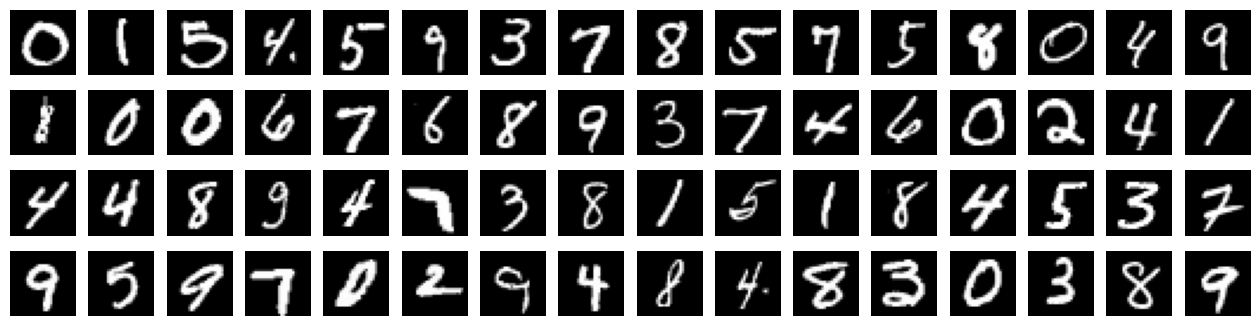

In [244]:
# Define a transform to normalize the data
transform3 = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the training dataset
train_dataset3 = torchvision.datasets.MNIST(root='./data', train=True, transform=transform3, download=True)
train_loader3 = torch.utils.data.DataLoader(train_dataset3, batch_size=64, shuffle=True)
val_dataset3 = torchvision.datasets.MNIST(root='./data', train=False, transform=transform3, download=True)
val_loader3 = torch.utils.data.DataLoader(val_dataset3, batch_size=64, shuffle=True)
# Extract a batch of unique images
unique_images, unique_labels = next(iter(train_loader3))
unique_images = unique_images.numpy()

# Display a grid of unique images
fig, axes = plt.subplots(4, 16, figsize=(16, 4), sharex=True, sharey=True)  # Create a 4x16 grid of subplots with a wider figure

for i in range(4):  # Loop over rows
    for j in range(16):  # Loop over columns
        index = i * 16 + j  # Calculate the index in the batch
        axes[i, j].imshow(unique_images[index].squeeze(), cmap='gray')  # Show the image using a grayscale colormap
        axes[i, j].axis('off')  # Turn off axis labels and ticks

plt.show()  # Display the plot

In [217]:
# Using GPU
device = "cuda"

# Marginal Probability Standard Deviation Function, computes the standard deviation of the noise that would be present at time 
𝑡
t in the forward diffusion process.
def marginal_prob_std(t, sigma):
    """
    Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The standard deviation.
    """
    # Convert time steps to a PyTorch tensor
    t = torch.tensor(t, device=device)
    
    # Calculate and return the standard deviation based on the given formula
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

In [259]:
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 2080 Ti


In [218]:

def diffusion_coeff(t, sigma):
    
    """
    Compute the diffusion coefficient of our SDE. that is how much noise is being added at time t

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The vector of diffusion coefficients.
    """
    # Calculate and return the diffusion coefficients based on the given formula
    return torch.tensor(sigma**t, device=device)

In [219]:
# Sigma Value
sigma =  25.0 # noise scaling factor

#create helper functions to calculate noise at timestep t
# marginal probability standard
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)

# diffusion coefficient
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [231]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1):
        """
        Initialize the CrossAttention module.
        integrates class label information into the denoising process, helping the model reconstruct an image that looks like the target digit.
        Parameters:
        - embed_dim: The dimensionality of the output embeddings.
        - hidden_dim: The dimensionality of the hidden representations.
        - context_dim: The dimensionality of the context representations (if not self attention).
        - num_heads: Number of attention heads (currently supports 1 head).

        """
        super(CrossAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim

        # Linear layer for query projection
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)
        
        # Check if self-attention or cross-attention
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)

    def forward(self, tokens, context=None):
        """
        Forward pass of the CrossAttention module.

        Parameters:
        - tokens: Input tokens with shape [batch, sequence_len, hidden_dim].
        - context: Context information with shape [batch, context_seq_len, context_dim].
                   If self_attn is True, context is ignored.

        Returns:
        - ctx_vecs: Context vectors after attention with shape [batch, sequence_len, embed_dim].
        """

        if self.self_attn:
            # Self-attention case
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            # Cross-attention case
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)

        # Compute score matrices, attention matrices, and context vectors
        scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # Inner product of Q and K, a tensor
        attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1)  # Softmax of scoremats
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # Weighted average value vectors by attnmats

        return ctx_vecs

In [232]:
class TransformerBlock(nn.Module):
    """The transformer block that combines self-attn, cross-attn, and feed forward neural net"""
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the TransformerBlock.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.

        Note: For simplicity, the self-attn and cross-attn use the same hidden_dim.
        """

        super(TransformerBlock, self).__init__()

        # Self-attention module
        self.attn_self = CrossAttention(hidden_dim, hidden_dim)

        # Cross-attention module
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

        # Layer normalization modules
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)

        # Implement a 2-layer MLP with K * hidden_dim hidden units, and nn.GELU nonlinearity
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )

    def forward(self, x, context=None):
        """
        Forward pass of the TransformerBlock.

        Parameters:
        - x: Input tensor with shape [batch, sequence_len, hidden_dim].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after passing through the TransformerBlock.
        """

        # Apply self-attention with layer normalization and residual connection
        x = self.attn_self(self.norm1(x)) + x

        # Apply cross-attention with layer normalization and residual connection
        x = self.attn_cross(self.norm2(x), context=context) + x

        # Apply feed forward neural network with layer normalization and residual connection
        x = self.ffn(self.norm3(x)) + x

        return x

In [233]:
class SpatialTransformer(nn.Module):
    # adapts a Transformer block to work with image feature maps.
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the SpatialTransformer.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.
        """
        super(SpatialTransformer, self).__init__()
        
        # TransformerBlock for spatial transformation
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        """
        Forward pass of the SpatialTransformer.

        Parameters:
        - x: Input tensor with shape [batch, channels, height, width].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after applying spatial transformation.
        """
        b, c, h, w = x.shape
        x_in = x

        # Combine the spatial dimensions and move the channel dimension to the end
        x = rearrange(x, "b c h w -> b (h w) c")

        # Apply the sequence transformer
        x = self.transformer(x, context)

        # Reverse the process
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

        # Residue connection
        return x + x_in

In [234]:
class UNet_Tranformer(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
                 text_dim=256, nClass=10):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings of time.
        - text_dim: The embedding dimension of text/digits.
        - nClass: Number of classes to model.
        """
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        """
        Forward pass of the UNet_Transformer model.

        Parameters:
        - x: Input tensor.
        - t: Time tensor.
        - y: Target tensor.

        Returns:
        - h: Output tensor after passing through the UNet_Transformer architecture.
        """
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)

        # Decoding path
        h = self.tconv4(h4) + self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [240]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models with conditional information.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - y: Conditional information (target tensor).
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.

    Returns:
    - loss: The calculated loss.
    """
    # Sample time uniformly in the range [eps, 1-eps], one for each sample in batch
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    # Generate random noise with the same shape as the input
    z = torch.randn_like(x)
    # Compute the standard deviation of the perturbation kernel at the sampled time
    std = marginal_prob_std(random_t)
    # Perturb the input data with the generated noise and scaled by the standard deviation
    perturbed_x = x + z * std[:, None, None, None]
    # Get the model's score for the perturbed input, considering conditional information
    score = model(perturbed_x, random_t, y=y)
    # Calculate the loss using the score and perturbation
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    return loss, random_t

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

/tmp/ipykernel_1030908/1064333810.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 1047.359319 lr 9.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

1 Average Loss: 326.366444 lr 9.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

2 Average Loss: 223.208872 lr 9.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

3 Average Loss: 166.896181 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

4 Average Loss: 133.294251 lr 9.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

5 Average Loss: 111.966515 lr 8.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

6 Average Loss: 97.124600 lr 8.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

7 Average Loss: 86.370354 lr 8.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

8 Average Loss: 78.136551 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

9 Average Loss: 72.187539 lr 8.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

10 Average Loss: 66.473915 lr 8.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

11 Average Loss: 62.579778 lr 7.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

12 Average Loss: 59.644473 lr 7.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

13 Average Loss: 56.501878 lr 7.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

14 Average Loss: 53.849030 lr 7.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

15 Average Loss: 51.838001 lr 7.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

16 Average Loss: 49.740631 lr 7.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

17 Average Loss: 47.793793 lr 7.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

18 Average Loss: 46.051996 lr 6.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

19 Average Loss: 44.495962 lr 6.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

20 Average Loss: 43.413992 lr 6.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

21 Average Loss: 42.157515 lr 6.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

22 Average Loss: 40.881886 lr 6.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

23 Average Loss: 39.759955 lr 6.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

24 Average Loss: 38.716097 lr 6.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

25 Average Loss: 37.811899 lr 5.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

26 Average Loss: 37.036895 lr 5.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

27 Average Loss: 36.274297 lr 5.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

28 Average Loss: 35.590314 lr 5.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

29 Average Loss: 35.124624 lr 5.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

30 Average Loss: 34.059619 lr 5.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

31 Average Loss: 33.490114 lr 5.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

32 Average Loss: 33.174247 lr 5.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

33 Average Loss: 32.168194 lr 5.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

34 Average Loss: 31.974721 lr 4.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

35 Average Loss: 31.893689 lr 4.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

36 Average Loss: 31.123582 lr 4.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

37 Average Loss: 30.705714 lr 4.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

38 Average Loss: 30.290180 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

39 Average Loss: 29.978327 lr 4.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

40 Average Loss: 29.532654 lr 4.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

41 Average Loss: 29.152841 lr 4.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

42 Average Loss: 28.880631 lr 4.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

43 Average Loss: 28.582231 lr 4.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

44 Average Loss: 28.286604 lr 4.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

45 Average Loss: 28.164734 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

46 Average Loss: 27.670968 lr 3.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

47 Average Loss: 27.489312 lr 3.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

48 Average Loss: 27.266188 lr 3.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

49 Average Loss: 26.934151 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

50 Average Loss: 26.742602 lr 3.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

51 Average Loss: 26.713528 lr 3.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

52 Average Loss: 26.382148 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

53 Average Loss: 25.850036 lr 3.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

54 Average Loss: 25.812237 lr 3.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

55 Average Loss: 25.683303 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

56 Average Loss: 25.554719 lr 3.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

57 Average Loss: 25.428689 lr 3.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

58 Average Loss: 25.280270 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

59 Average Loss: 25.131577 lr 3.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

60 Average Loss: 25.091716 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

61 Average Loss: 24.864248 lr 2.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

62 Average Loss: 24.671838 lr 2.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

63 Average Loss: 24.539640 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

64 Average Loss: 24.345051 lr 2.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

65 Average Loss: 24.221812 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

66 Average Loss: 24.253089 lr 2.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

67 Average Loss: 23.925194 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

68 Average Loss: 23.907368 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

69 Average Loss: 23.693952 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

70 Average Loss: 23.711981 lr 2.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

71 Average Loss: 23.495047 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

72 Average Loss: 23.480397 lr 2.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

73 Average Loss: 23.096366 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

74 Average Loss: 23.455950 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

75 Average Loss: 22.977356 lr 2.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

76 Average Loss: 23.112166 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

77 Average Loss: 23.079866 lr 2.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

78 Average Loss: 22.894164 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

79 Average Loss: 22.850798 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

80 Average Loss: 22.625763 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

81 Average Loss: 22.543281 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

82 Average Loss: 22.510524 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

83 Average Loss: 22.611547 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

84 Average Loss: 22.381479 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

85 Average Loss: 22.443518 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

86 Average Loss: 22.278257 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

87 Average Loss: 22.344646 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

88 Average Loss: 22.249059 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

89 Average Loss: 22.352967 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

90 Average Loss: 21.999906 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

91 Average Loss: 21.879626 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

92 Average Loss: 21.786756 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

93 Average Loss: 21.697244 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

94 Average Loss: 21.524902 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

95 Average Loss: 21.440131 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

96 Average Loss: 21.436874 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

97 Average Loss: 21.312875 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

98 Average Loss: 21.300794 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

99 Average Loss: 21.294934 lr 2.0e-04


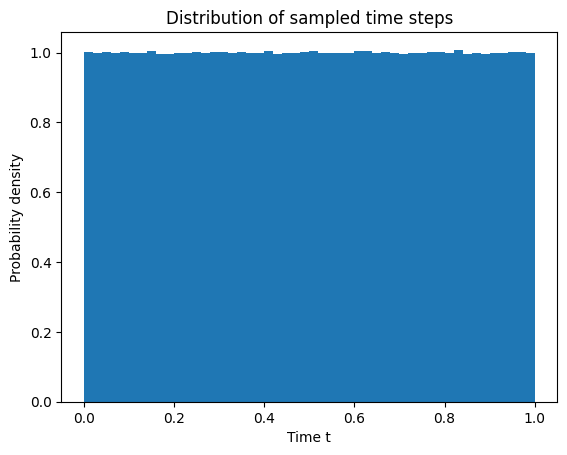

In [241]:
# Specify whether to continue training or initialize a new model

continue_training = False # Either True or False

if not continue_training:
    
    # Initialize a new UNet with Transformer model
    score_model = torch.nn.DataParallel(UNet_Tranformer(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)

# Set training hyperparameters
n_epochs =   100   #{'type':'integer'}
batch_size =  1024 #{'type':'integer'}
lr = 10e-4         #{'type':'number'}

# Load the MNIST dataset and create a data loader
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define the optimizer and learning rate scheduler
optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

# Use tqdm to display a progress bar over epochs
tqdm_epoch = trange(n_epochs)
# Collect t samples over batches
all_t = []
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0

    # Iterate over batches in the data loader
    for x, y in tqdm(data_loader):
        x = x.to(device)

        # Compute the loss using the conditional score-based model
        loss, random_t = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
        all_t.append(random_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust learning rate using the scheduler
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    # Print epoch information including average loss and current learning rate
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    # Save the model checkpoint after each epoch of training
    torch.save(score_model.state_dict(), 'ckpt_transformer.pth')

t_vals = torch.cat(all_t).cpu().numpy()
plt.hist(t_vals, bins=50, density=True)
plt.xlabel("Time t")
plt.ylabel("Probability density")
plt.title("Distribution of sampled time steps")
plt.show()

/tmp/ipykernel_1030908/1064333810.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_1030908/706301213.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


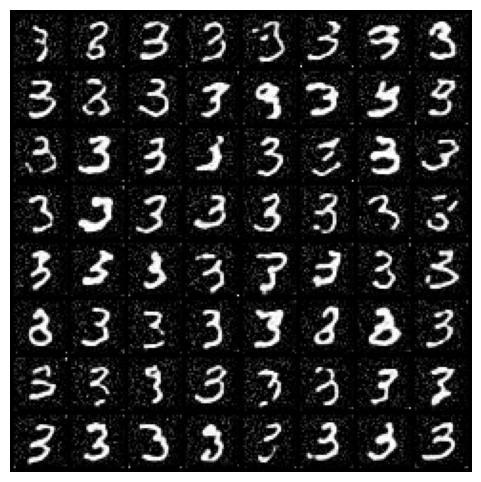

In [260]:
## Load the pre-trained checkpoint from disk.
# device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt_transformer.pth', map_location=device)
score_model.load_state_dict(ckpt)


########### Specify the digit for which to generate samples
###########
digit = 3 #@param {'type':'integer'}
###########
###########



# Set the batch size for generating samples
sample_batch_size = 64 #@param {'type':'integer'}
# Set the number of steps for the Euler-Maruyama sampler
num_steps = 250 #@param {'type':'integer'}
# Choose the sampler type (Euler-Maruyama, pc_sampler, ode_sampler)
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
# score_model.eval()

## Generate samples using the specified sampler.
samples = sampler(score_model,
        marginal_prob_std_fn,
        diffusion_coeff_fn,
        sample_batch_size,
        num_steps=num_steps,
        device=device,
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
# Create a grid of samples for visualization
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the generated samples
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [251]:
# An extra loss function to assist in investigating loss for different time steps

def loss_fn_cond_per_sample(model, x, y, marginal_prob_std, sigma, eps=1e-5):
    batch_size = x.shape[0]
    t = torch.rand(batch_size, device=x.device) * (1. - eps) + eps
    z = torch.randn_like(x)
    std = marginal_prob_std(t, sigma)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, t, y=y)

    # Per-sample losses (no mean)
    loss_per_sample = torch.sum((score * std[:, None, None, None] + z) ** 2, dim=(1, 2, 3))
    return loss_per_sample.detach().cpu(), t.detach().cpu()


In [252]:
# Store losses for different time-steps in all-losses for plotting
all_losses = []
all_ts = []

for x_batch, y_batch in val_loader3:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    losses, ts = loss_fn_cond_per_sample(score_model, x_batch, y_batch, marginal_prob_std, sigma = 25.0)
    all_losses.append(losses)
    all_ts.append(ts)

# Flatten
all_losses = torch.cat(all_losses).numpy()
all_ts = torch.cat(all_ts).numpy()

/tmp/ipykernel_1030908/1064333810.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


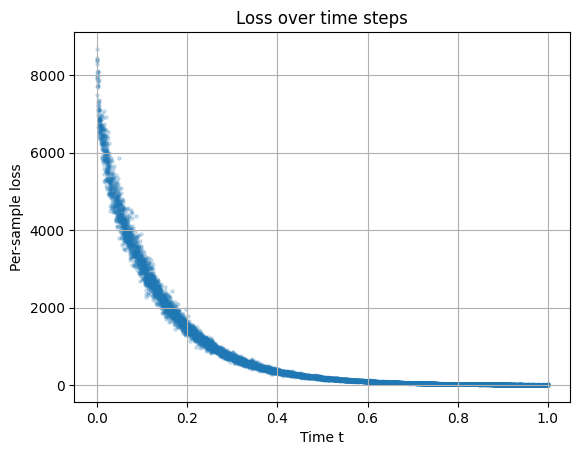

In [254]:
# Plot the loss per time-step, obviously it is most uncertain for low time-steps, that is creating the fine details.

import matplotlib.pyplot as plt

plt.scatter(all_ts, all_losses, alpha=0.2, s=5)
plt.xlabel("Time t")
plt.ylabel("Per-sample loss")
plt.title("Loss over time steps")
plt.grid(True)
plt.show()


In [ ]:
# Below here code used for understanding stable diffusion but not actually involved in the lab tasks.

In [209]:
# Forward diffusion for N steps in 1D.
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - t0: Initial time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)
    
    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = t0 + np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for diffusion simulation
    for i in range(nsteps):

        # Get the noise strength at the current time
        noise_strength = noise_strength_fn(t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using Euler-Maruyama method
        x[i + 1] = x[i] + random_normal * noise_strength

    # Return the trajectory and corresponding time points
    return x, t

In [210]:
# Example noise strength function: always equal to 1
def noise_strength_constant(t):
    """
    Example noise strength function that returns a constant value (1).

    Parameters:
    - t: Time parameter (unused in this example)

    Returns:
    - Constant noise strength (1)
    """
    return 1

In [215]:
# Define a module for Gaussian random features used to encode time steps.
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        """
        Parameters:
        - embed_dim: Dimensionality of the embedding (output dimension)
        - scale: Scaling factor for random weights (frequencies)
        """
        super().__init__()

        # Randomly sample weights (frequencies) during initialization.
        # These weights (frequencies) are fixed during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor representing time steps
        """
        # Calculate the cosine and sine projections: Cosine(2 pi freq x), Sine(2 pi freq x)
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi

        # Concatenate the sine and cosine projections along the last dimension
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

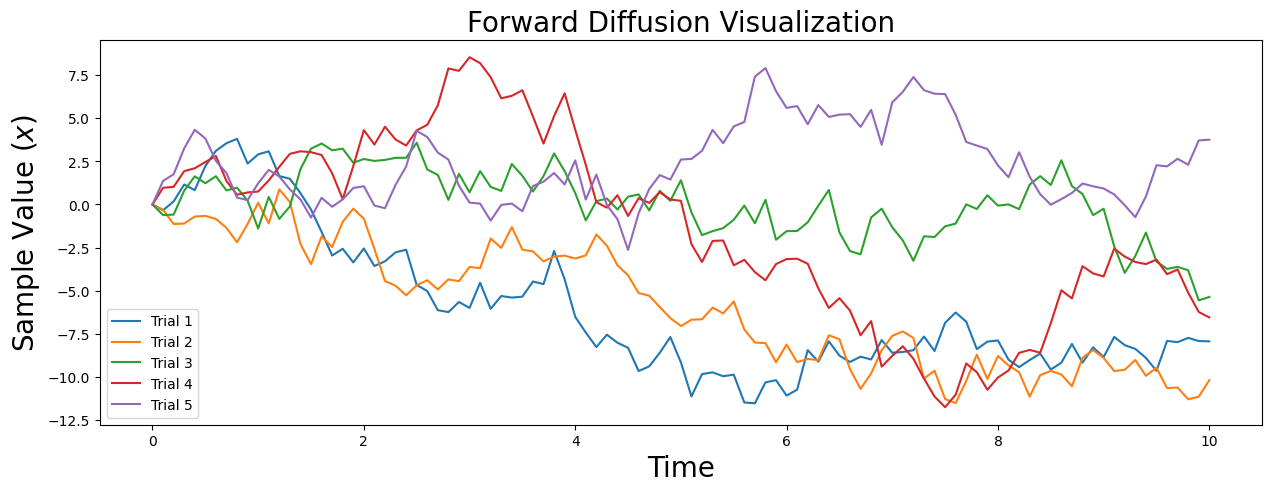

In [211]:
# Number of diffusion steps
nsteps = 100

# Initial time
t0 = 0

# Time step size
dt = 0.1

# Noise strength function
noise_strength_fn = noise_strength_constant

# Initial sample value
x0 = 0

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 5))

# Loop for multiple trials
for i in range(num_tries):

    # Simulate forward diffusion
    x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)

# Title of the plot
plt.title('Forward Diffusion Visualization', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()

In [212]:
# Reverse diffusion for N steps in 1D.
def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - score_fn: Score function
    - T: Final time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)
    
    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for reverse diffusion simulation
    for i in range(nsteps):

        # Calculate noise strength at the current time
        noise_strength = noise_strength_fn(T - t[i])

        # Calculate the score using the score function
        score = score_fn(x[i], 0, noise_strength, T - t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using the reverse Euler-Maruyama method
        x[i + 1] = x[i] + score * noise_strength**2 * dt + noise_strength * random_normal * np.sqrt(dt)

    # Return the trajectory and corresponding time points
    return x, t

In [213]:
# Example score function: always equal to 1
def score_simple(x, x0, noise_strength, t):
    """
    Parameters:
    - x: Current sample value (scalar)
    - x0: Initial sample value (scalar)
    - noise_strength: Scalar noise strength at the current time
    - t: Current time

    Returns:
    - score: Score calculated based on the provided formula
    """

    # Calculate the score using the provided formula
    score = - (x - x0) / ((noise_strength**2) * t)

    # Return the calculated score
    return score

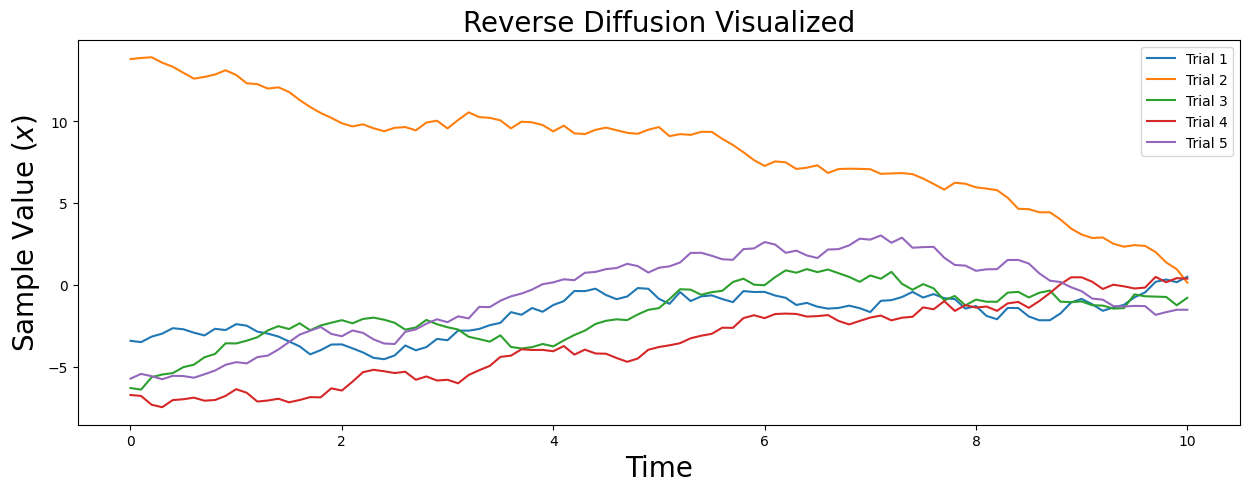

In [214]:
# Number of reverse diffusion steps
nsteps = 100

# Initial time for reverse diffusion
t0 = 0

# Time step size for reverse diffusion
dt = 0.1

# Function defining constant noise strength for reverse diffusion
noise_strength_fn = noise_strength_constant

# Example score function for reverse diffusion
score_fn = score_simple

# Initial sample value for reverse diffusion
x0 = 0

# Final time for reverse diffusion
T = 11

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 5))

# Loop for multiple trials
for i in range(num_tries):
    # Draw from the noise distribution, which is diffusion for time T with noise strength 1
    x0 = np.random.normal(loc=0, scale=T)

    # Simulate reverse diffusion
    x, t = reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)

# Title of the plot
plt.title('Reverse Diffusion Visualized', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()

In [215]:
# Define a module for Gaussian random features used to encode time steps.
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        """
        Parameters:
        - embed_dim: Dimensionality of the embedding (output dimension)
        - scale: Scaling factor for random weights (frequencies)
        """
        super().__init__()

        # Randomly sample weights (frequencies) during initialization.
        # These weights (frequencies) are fixed during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor representing time steps
        """
        # Calculate the cosine and sine projections: Cosine(2 pi freq x), Sine(2 pi freq x)
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi

        # Concatenate the sine and cosine projections along the last dimension
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

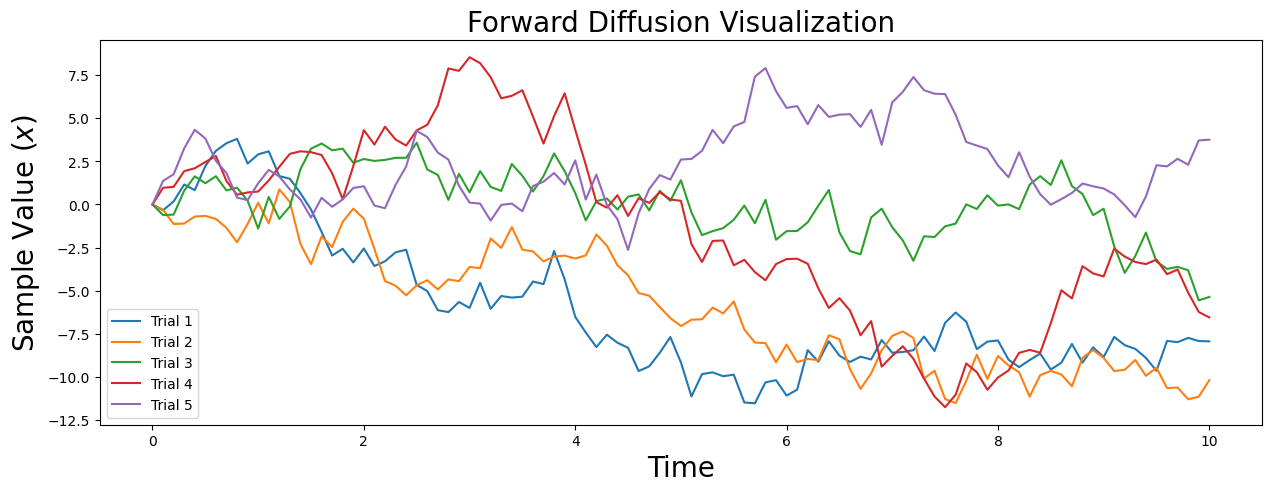

In [211]:
# Number of diffusion steps
nsteps = 100

# Initial time
t0 = 0

# Time step size
dt = 0.1

# Noise strength function
noise_strength_fn = noise_strength_constant

# Initial sample value
x0 = 0

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 5))

# Loop for multiple trials
for i in range(num_tries):

    # Simulate forward diffusion
    x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)

# Title of the plot
plt.title('Forward Diffusion Visualization', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()

In [212]:
# Reverse diffusion for N steps in 1D.
def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - score_fn: Score function
    - T: Final time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)
    
    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for reverse diffusion simulation
    for i in range(nsteps):

        # Calculate noise strength at the current time
        noise_strength = noise_strength_fn(T - t[i])

        # Calculate the score using the score function
        score = score_fn(x[i], 0, noise_strength, T - t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using the reverse Euler-Maruyama method
        x[i + 1] = x[i] + score * noise_strength**2 * dt + noise_strength * random_normal * np.sqrt(dt)

    # Return the trajectory and corresponding time points
    return x, t

In [213]:
# Example score function: always equal to 1
def score_simple(x, x0, noise_strength, t):
    """
    Parameters:
    - x: Current sample value (scalar)
    - x0: Initial sample value (scalar)
    - noise_strength: Scalar noise strength at the current time
    - t: Current time

    Returns:
    - score: Score calculated based on the provided formula
    """

    # Calculate the score using the provided formula
    score = - (x - x0) / ((noise_strength**2) * t)

    # Return the calculated score
    return score

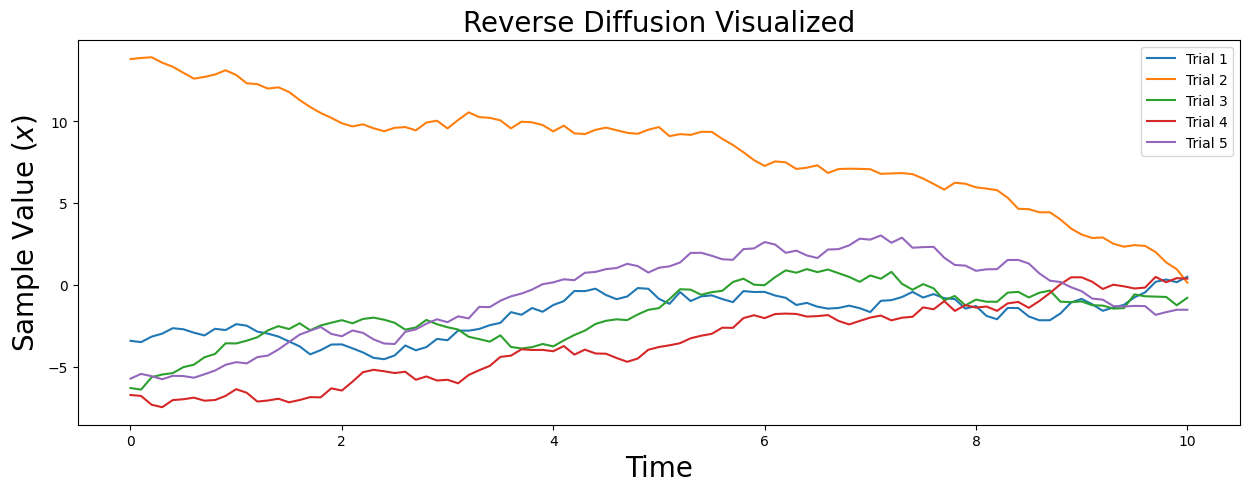

In [214]:
# Number of reverse diffusion steps
nsteps = 100

# Initial time for reverse diffusion
t0 = 0

# Time step size for reverse diffusion
dt = 0.1

# Function defining constant noise strength for reverse diffusion
noise_strength_fn = noise_strength_constant

# Example score function for reverse diffusion
score_fn = score_simple

# Initial sample value for reverse diffusion
x0 = 0

# Final time for reverse diffusion
T = 11

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 5))

# Loop for multiple trials
for i in range(num_tries):
    # Draw from the noise distribution, which is diffusion for time T with noise strength 1
    x0 = np.random.normal(loc=0, scale=T)

    # Simulate reverse diffusion
    x, t = reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)

# Title of the plot
plt.title('Reverse Diffusion Visualized', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()

In [216]:
# Define a module for a fully connected layer that reshapes outputs to feature maps.
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Parameters:
        - input_dim: Dimensionality of the input features
        - output_dim: Dimensionality of the output features
        """
        super().__init__()

        # Define a fully connected layer
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor

        Returns:
        - Output tensor after passing through the fully connected layer
          and reshaping to a 4D tensor (feature map)
        """

        # Apply the fully connected layer and reshape the output to a 4D tensor
        return self.dense(x)[..., None, None]
        # This broadcasts the 2D tensor to a 4D tensor, adding the same value across space.

In [222]:
# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet_res(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3)
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2)
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [226]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """
    The loss function for training score-based generative models.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.
    """
    # Sample time uniformly in the range (eps, 1-eps)
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - 2 * eps) + eps
    # Find the noise std at the sampled time `t`
    std = marginal_prob_std(random_t)
    
    # Generate normally distributed noise
    z = torch.randn_like(x)
    
    # Perturb the input data with the generated noise
    perturbed_x = x + z * std[:, None, None, None]
    
    # Get the score from the model using the perturbed data and time
    score = model(perturbed_x, random_t)
    
    # Calculate the loss based on the score and noise
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    
    return loss

In [220]:
# number of steps
num_steps = 500

def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           x_shape=(1, 28, 28),
                           num_steps=num_steps,
                           device='cuda',
                           eps=1e-3, y=None):
    """
    Generate samples from score-based models with the Euler-Maruyama solver.

    Parameters:
    - score_model: A PyTorch model that represents the time-dependent score-based model.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    - batch_size: The number of samplers to generate by calling this function once.
    - x_shape: The shape of the samples.
    - num_steps: The number of sampling steps, equivalent to the number of discretized time steps.
    - device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    - eps: The smallest time step for numerical stability.
    - y: Target tensor (not used in this function).

    Returns:
    - Samples.
    """

    # Initialize time and the initial sample
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]
    
    # Generate time steps
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    
    # Sample using Euler-Maruyama method
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
    
    # Do not include any noise in the last sampling step.
    return mean_x

In [227]:
# Define the score-based model and move it to the specified device
score_model = torch.nn.DataParallel(UNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Number of training epochs
n_epochs = 50
# Size of a mini-batch
batch_size = 2048
# Learning rate
lr = 5e-4

# Load the MNIST dataset and create a data loader
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define the Adam optimizer for training the model
optimizer = Adam(score_model.parameters(), lr=lr)

# Progress bar for epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate through mini-batches in the data loader
    for x, y in tqdm(data_loader):
        x = x.to(device)
        # Calculate the loss and perform backpropagation
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    # Print the averaged training loss for the current epoch
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Save the model checkpoint after each epoch of training
    torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_1030908/1064333810.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipykernel_1030908/1064333810.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_1030908/706301213.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


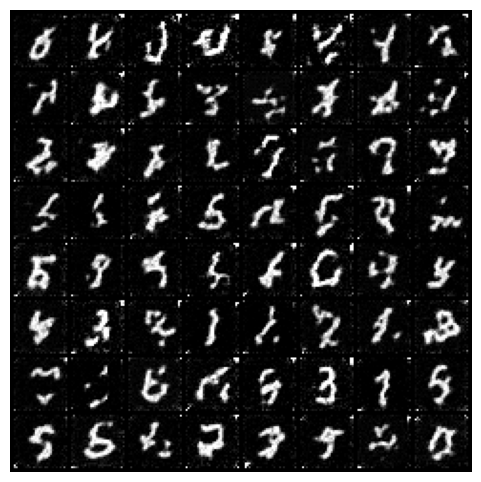

In [228]:
# Load the pre-trained checkpoint from disk.
device = 'cuda'

# Load the pre-trained model checkpoint
ckpt = torch.load('ckpt.pth', map_location=device)
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 64
num_steps = 500

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [229]:
# Initialize the  U-Net model for training.
score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Set the number of training epochs, mini-batch size, and learning rate.
n_epochs = 75
batch_size = 1024
lr = 1e-3

# Load the MNIST dataset for training.
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Initialize the Adam optimizer with the specified learning rate.
optimizer = Adam(score_model.parameters(), lr=lr)
# Learning rate scheduler to adjust the learning rate during training.
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

# Training loop over epochs.
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate over mini-batches in the training data loader.
    for x, y in data_loader:
        x = x.to(device)
        # Compute the loss for the current mini-batch.
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        # Zero the gradients, backpropagate, and update the model parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Accumulate the total loss and the number of processed items.
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    
    # Adjust the learning rate using the scheduler.
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]
    
    # Print the average loss and learning rate for the current epoch.
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    
    # Save the model checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ckpt_res.pth')

  0%|          | 0/75 [00:00<?, ?it/s]

/tmp/ipykernel_1030908/1064333810.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


0 Average Loss: 667.371987 lr 9.8e-04
1 Average Loss: 204.623650 lr 9.6e-04
2 Average Loss: 134.349117 lr 9.4e-04
3 Average Loss: 103.271698 lr 9.2e-04
4 Average Loss: 86.726857 lr 9.0e-04
5 Average Loss: 75.461772 lr 8.9e-04
6 Average Loss: 67.844337 lr 8.7e-04
7 Average Loss: 61.730874 lr 8.5e-04
8 Average Loss: 57.566191 lr 8.3e-04
9 Average Loss: 54.006506 lr 8.2e-04
10 Average Loss: 51.155328 lr 8.0e-04
11 Average Loss: 48.872919 lr 7.8e-04
12 Average Loss: 46.553463 lr 7.7e-04
13 Average Loss: 45.175942 lr 7.5e-04
14 Average Loss: 43.857516 lr 7.4e-04
15 Average Loss: 41.982394 lr 7.2e-04
16 Average Loss: 40.701943 lr 7.1e-04
17 Average Loss: 39.381392 lr 7.0e-04
18 Average Loss: 38.676291 lr 6.8e-04
19 Average Loss: 37.940436 lr 6.7e-04
20 Average Loss: 36.818747 lr 6.5e-04
21 Average Loss: 35.286884 lr 6.4e-04
22 Average Loss: 35.148552 lr 6.3e-04
23 Average Loss: 34.213762 lr 6.2e-04
24 Average Loss: 33.128928 lr 6.0e-04
25 Average Loss: 33.239549 lr 5.9e-04
26 Average Loss: 3

/tmp/ipykernel_1030908/1064333810.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_1030908/706301213.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


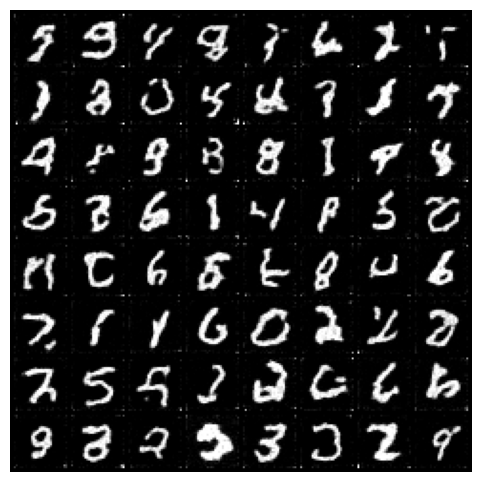

In [230]:
# Load the pre-trained checkpoint from disk.
device = 'cuda'

# Load the pre-trained model checkpoint
ckpt = torch.load('ckpt_res.pth', map_location=device)
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 64
num_steps = 500

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()